# Text-Deconfounded Factorization Model (TDFM)

This notebook trains and evaluates:
- **MF baseline** (ratings-only)
- **TDFM hybrid model** (ratings + text topics + exposure), using the *same train/test split* (no text leakage)

Sections:
1. Reproducibility utilities (seed + shared split indices)
2. Shared data preparation (data loading via fetch+preprocess or `clean_reviews.csv`; vectorizer fit on train only)
3. Dataloaders (MF and TDFM share the exact same split)
4. MF baseline (same split)
5. TDFM model + training (same split)
6. Run MF vs TDFM + summary (same split, no leakage)
7. Topic inspection (uses saved vocab + full hybrid checkpoint; no vectorizer rebuild)
8. Robustness upgrades (trained ablation / topic-collapse diagnostics / ranking sweep)


## How to run this notebook (reproducible)

1. **Restart kernel → Run All** (recommended).
2. This notebook will (re)create these local artifacts:
   - `clean_reviews.csv` (cleaned dataset)
   - `split_idx.pt` (fixed train/test indices shared by MF and TDFM)
   - `tdfm_vocab.npy` (CountVectorizer vocab **fit on train only**)
   - `tdfm_model_seed*.pt` (and related checkpoint files, depending on your seed loop)
   - `confounders_baseline.pt` is **optional** (if present, it provides an exposure/confounder proxy for deconfounded ranking / IPW evaluation).

**Runtime knobs:** `EPOCHS`, number of seeds, bootstrap iterations `B`, and ranking sweep grid (`N_NEG × K`) control total runtime.

**Expected outputs:** (i) MF vs TDFM rating metrics (RMSE/MAE) with bootstrap CIs, (ii) ranking metrics (Recall@K/NDCG@K) with negative sampling sweeps, (iii) topic inspection + collapse diagnostics, and (iv) trained no-topic ablation (fair ablation) results.


In [ ]:
# --- Imports & global settings ---
import os, random
import numpy as np
import pandas as pd
import re, html
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

# --- Experiment hyperparameters ---
SEED = 0

NUM_TOPICS = 10
EMBEDDING_DIM = 8
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-4

# Text settings
MAX_FEATURES = 1000
STOP_WORDS = "english"

CSV_PATH = "clean_reviews.csv"
CONFOUNDER_PATH = "confounders_baseline.pt"   # optional
SPLIT_PATH = "split_idx.pt"

DEVICE = "cpu" 
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", DEVICE)

In [ ]:
from ucimlrepo import fetch_ucirepo

def load_and_process_data(min_interactions=2):
    print("Step 1: Fetching data from UCI Repository (ID=911)...")
    
    try:
        # Fetch dataset
        recipe_data = fetch_ucirepo(id=911)
        X = recipe_data.data.features
        y = recipe_data.data.targets
        
        # Combine into one DataFrame
        df = pd.concat([X, y], axis=1)
        
        # --- Map the actual columns found ---
        # Output: ['user_id', 'recipe_code', 'stars', 'text', ...]
        df = df.rename(columns={
            'recipe_code': 'item_id',  # Unique ID for the recipe
            'stars': 'rating',         # The target variable
            'text': 'review'           # The text for LDA
        })
        
        # Ensure user_id is treated as string/ID
        df['user_id'] = df['user_id'].astype(str)
        
        print(f"Initial shape: {df.shape}")
        
    except Exception as e:
        print(f"Failed to fetch data: {e}")
        return None

    # Drop rows where critical data is missing
    df = df.dropna(subset=['rating', 'review', 'user_id', 'item_id'])
    
    # --- Step 2: Iterative Filtering (Core "Dense" Requirement) ---
    # This loop removes sparse users, then sparse items, then checks again...
    # untill both users and items all have > min_interactions.
    print(f"Step 2: Filtering for dense interactions (> {min_interactions})...")
    
    initial_rows = len(df)
    while True:
        user_counts = df.groupby('user_id').size()
        item_counts = df.groupby('item_id').size()
        
        valid_users = user_counts[user_counts >= min_interactions].index
        valid_items = item_counts[item_counts >= min_interactions].index
        
        old_shape = df.shape
        df = df[df['user_id'].isin(valid_users) & df['item_id'].isin(valid_items)]
        
        if df.shape == old_shape:
            break
            
    print(f"Final filtered shape: {df.shape} (Removed {initial_rows - len(df)} rows)")
    print(f"Unique Users: {df['user_id'].nunique()}")
    print(f"Unique Recipes: {df['item_id'].nunique()}")

    return df

def save_preprocessed_data(df):
    print("Step 3: Saving clean data to 'clean_reviews.csv'...")
    df.to_csv("clean_reviews.csv", index=False)
    print("Done! You can now load this CSV for your model training.")

In [3]:
df = load_and_process_data(min_interactions=2)
if df is not None:
    save_preprocessed_data(df)

Step 1: Fetching data from UCI Repository (ID=911)...
Initial shape: (18182, 15)
Step 2: Filtering for dense interactions (> 2)...
Final filtered shape: (6478, 15) (Removed 11702 rows)
Unique Users: 2110
Unique Recipes: 100
Step 3: Saving clean data to 'clean_reviews.csv'...
Done! You can now load this CSV for your model training.


Loading data...
After dropping zeros: 6085 rows; rating min/max: 1 5
Dataset Stats: 2021 Users, 100 Items, 6085 Interactions
Initializing Poisson Factorization (K=20)...
Epoch 0: Loss = 24755.0098
Epoch 20: Loss = 17526.0391
Epoch 40: Loss = 15140.1084
Epoch 60: Loss = 13411.6123
Epoch 80: Loss = 12487.6270
Epoch 100: Loss = 12005.3574
Epoch 120: Loss = 11728.8945
Epoch 140: Loss = 11579.7070
Epoch 160: Loss = 11527.9326
Epoch 180: Loss = 11515.2891
Epoch 200: Loss = 11512.5273
Epoch 220: Loss = 11511.8242
Epoch 240: Loss = 11511.5029
Epoch 260: Loss = 11511.3232
Epoch 280: Loss = 11511.2178
Epoch 300: Loss = 11511.1533
Epoch 320: Loss = 11511.1113
Epoch 340: Loss = 11511.0830
Epoch 360: Loss = 11511.0645
Epoch 380: Loss = 11511.0518
Epoch 400: Loss = 11511.0430
Epoch 420: Loss = 11511.0361
Epoch 440: Loss = 11511.0312
Epoch 460: Loss = 11511.0293
Epoch 480: Loss = 11511.0264


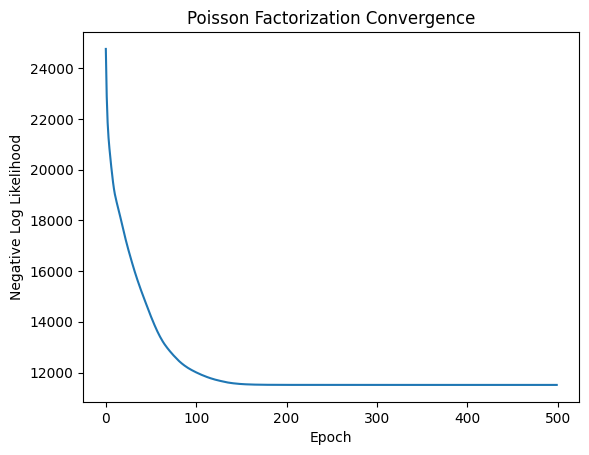


Training Complete.
Learned Confounder Matrix Shape: torch.Size([2021, 100])
Example Confounder values for User 0: [1.9385606e-09 1.5309554e-09 1.9856607e-09 1.7335987e-09 1.3577460e-09]
Baseline confounders saved to 'confounders_baseline.pt'


In [ ]:
# --- 1. Data Loading & Matrix Construction ---
def load_data(filepath='clean_reviews.csv'):
    print("Loading data...")
    df = pd.read_csv(filepath)
    # drop missing/placeholder ratings (keep only 1–5)
    df = df[df["rating"] > 0].copy().reset_index(drop=True)
    print("After dropping zeros:", len(df), "rows; rating min/max:", df["rating"].min(), df["rating"].max())

    # Ensure IDs are strings so mapping keys match exactly
    df['user_id'] = df['user_id'].astype(str)
    df['item_id'] = df['item_id'].astype(str)
    
    # Map IDs to contiguous integers (0 to N-1)
    # We do this to ensure we can index into our embedding matrices correctly
    u_unique = np.sort(df['user_id'].unique())
    i_unique = np.sort(df['item_id'].unique())
    
    user_map = {uid: idx for idx, uid in enumerate(u_unique)}
    item_map = {iid: idx for idx, iid in enumerate(i_unique)}
    
    df['u_idx'] = df['user_id'].map(user_map)
    df['i_idx'] = df['item_id'].map(item_map)

    # Safety check: mapping should not create missing indices
    if df['u_idx'].isna().any() or df['i_idx'].isna().any():
        bad = df[df['u_idx'].isna() | df['i_idx'].isna()][['user_id','item_id']].head(5)
        raise ValueError(f"Found unmapped user/item ids. Example rows:\n{bad}")
    df['u_idx'] = df['u_idx'].astype(np.int64)
    df['i_idx'] = df['i_idx'].astype(np.int64)
    
    num_users = len(u_unique)
    num_items = len(i_unique)
    
    print(f"Dataset Stats: {num_users} Users, {num_items} Items, {len(df)} Interactions")
    
    # Create the Full Exposure Matrix A (Dense)
    # Since the dataset is filtered and dense (approx 2000x100), we can handle 
    # the full matrix in memory easily. This simplifies the math implementation.
    A = torch.zeros((num_users, num_items))
    A[df['u_idx'].values, df['i_idx'].values] = 1.0
    
    return A, df, num_users, num_items, u_unique, i_unique

# --- 2. The Probabilistic Model (Poisson Factorization) ---
class PoissonFactorization(nn.Module):
    def __init__(self, num_users, num_items, k=10):
        super().__init__()
        # Dimensions
        self.k = k
        
        # Latent Factors (Theta and Beta in generic terms, or Pi/Lambda in Wang et al)
        # We initialize them to be positive (Poisson parameters must be > 0)
        self.user_factors = nn.Parameter(torch.rand(num_users, k) * 0.1)
        self.item_factors = nn.Parameter(torch.rand(num_items, k) * 0.1)
        
    def forward(self):
        # Reconstruct the expected count matrix
        # A_hat = Theta * Beta^T
        return torch.matmul(self.user_factors, self.item_factors.t())

    def get_substitute_confounder(self):
        # According to Wang et al., the substitute confounder is the 
        # predicted exposure probability (or rate)
        with torch.no_grad():
            return self.forward()

# --- 3. Training Loop ---
def train_baseline(A_matrix, num_users, num_items, epochs=200, lr=0.01, k=20):
    print(f"Initializing Poisson Factorization (K={k})...")
    model = PoissonFactorization(num_users, num_items, k=k)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # We create a simple holdout mask to verify it's actually learning
    # (Randomly hide 10% of interactions just for validation monitoring)
    mask = torch.rand_like(A_matrix) > 0.1 
    A_train = A_matrix * mask
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass: Get predicted rates (lambda)
        rate_hat = model()
        
        # Poisson Log-Likelihood Loss
        # Loss = sum( rate_hat - A * log(rate_hat) )
        # We add a small epsilon to log to prevent NaN
        epsilon = 1e-9
        loss = torch.sum(rate_hat - A_train * torch.log(rate_hat + epsilon))
        
        loss.backward()
        optimizer.step()
        
        # Constraint: Factors must be non-negative for Poisson
        # We clamp them after every update
        with torch.no_grad():
            model.user_factors.clamp_(min=epsilon)
            model.item_factors.clamp_(min=epsilon)
            
        losses.append(loss.item())
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
            
    # Visualize convergence
    plt.plot(losses)
    plt.title("Poisson Factorization Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Negative Log Likelihood")
    plt.show()
    
    return model

# --- Execution ---
if __name__ == "__main__":
    # 1. Prepare Data
    try:
        A, df, n_u, n_i, user_ids, item_ids = load_data()
        
        # 2. Train Model
        pf_model = train_baseline(A, n_u, n_i, epochs=500, k=20)
        
        # 3. Get Confounders
        # This Z_matrix is what we will use in the next step to "correct" 
        # the Matrix Factorization for ratings
        Z_hat = pf_model.get_substitute_confounder()
        
        print("\nTraining Complete.")
        print(f"Learned Confounder Matrix Shape: {Z_hat.shape}")
        print("Example Confounder values for User 0:", Z_hat[0, :5].numpy())
        
        # Save the confounders for the next phase (TDFM)
        save_obj = {'Z_hat': Z_hat, 'user_ids': [str(x) for x in user_ids], 'item_ids': [str(x) for x in item_ids]}
        torch.save(save_obj, 'confounders_baseline.pt')
        print("Baseline confounders saved to 'confounders_baseline.pt'")
        
    except FileNotFoundError:
        print("Error: 'clean_reviews.csv' not found. Please run the preprocessing script first.")

### 1. Reproducibility utilities (seed + shared split indices)

In [ ]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def make_split_indices(n, seed=0, train_frac=0.8, save_path="split_idx.pt"):
    """Generate and save a single split that all models reuse."""
    g = torch.Generator().manual_seed(seed)
    perm = torch.randperm(n, generator=g).tolist()
    train_size = int(train_frac * n)
    split = {
        "train_idx": perm[:train_size],
        "test_idx": perm[train_size:],
        "seed": seed,
        "train_frac": train_frac,
        "n": n,
    }
    assert len(split["train_idx"]) + len(split["test_idx"]) == n
    assert set(split["train_idx"]).isdisjoint(set(split["test_idx"]))
    assert min(perm) >= 0 and max(perm) < n
    torch.save(split, save_path)
    return split

def load_or_make_split(n, seed=0, train_frac=0.8, save_path="split_idx.pt"):
    if os.path.exists(save_path):
        split = torch.load(save_path)
        if split.get("n", None) != n:
            print(f"[split] Existing {save_path} has n={split.get('n')}, current n={n}. Regenerating.")
            split = make_split_indices(n, seed=seed, train_frac=train_frac, save_path=save_path)
        return split
    return make_split_indices(n, seed=seed, train_frac=train_frac, save_path=save_path)


### 2. Shared data preparation (no text leakage)

This section builds the **shared tensors** used by both MF and TDFM:

- We first create (or load) a **fixed train/test split by row index** (`split_idx.pt`).
- We fit the `CountVectorizer` **on training reviews text only**, then transform *all* rows using that train-fit vocabulary.

#### Exposure / confounder proxy (optional)

Some experiments use an **exposure proxy** $z_{ui}$ (a scalar per user–item pair) to control for *who was likely to see what*.

- The file `confounders_baseline.pt` is **optional**. If present, this notebook expects it to contain either:
  - a tensor `Z_hat` of shape `[n_users, n_items]`, or
  - a dict with key `'Z_hat'` (and optionally saved `user_ids` / `item_ids` for defensive alignment).
- We treat `Z_hat[u,i]` as a **fixed, precomputed propensity/exposure score**: **larger values mean the user–item pair is considered more “exposed”** (e.g., more likely to be shown / encountered due to popularity or logging policy).
- For strict experimental hygiene, `Z_hat` should be computed **from interaction-only information** and ideally **using the training split** (so evaluation does not indirectly use test rows).
- If the file is missing, we set exposure to zeros and TDFM reduces to a text-augmented MF model without exposure adjustment.

In [ ]:
def clean_text(s: str) -> str:
    s = html.unescape(str(s))
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def prepare_common_tensors(
    csv_path=CSV_PATH,
    confounder_path=CONFOUNDER_PATH,
    max_features=MAX_FEATURES,
    stop_words=STOP_WORDS,
    seed=SEED,
    split_path=SPLIT_PATH,
):
    set_seed(seed)
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing {csv_path}. Create it first.")

    df = pd.read_csv(csv_path).copy()
    # Drop missing/placeholder ratings
    df = df[df["rating"] > 0].copy().reset_index(drop=True)
    print("After dropping zeros:", len(df), "rows; rating min/max:", df["rating"].min(), df["rating"].max())

    # Make sure IDs are consistent strings
    df["user_id"] = df["user_id"].astype(str).str.strip()
    df["item_id"] = df["item_id"].astype(str).str.strip()

    u_unique = np.sort(df["user_id"].unique())
    i_unique = np.sort(df["item_id"].unique())
    user_map = {uid: idx for idx, uid in enumerate(u_unique)}
    item_map = {iid: idx for idx, iid in enumerate(i_unique)}

    df["u_idx"] = df["user_id"].map(user_map)
    df["i_idx"] = df["item_id"].map(item_map)

    # Safety check (this is what prevents the IntCastingNaNError)
    if df["u_idx"].isna().any() or df["i_idx"].isna().any():
        print("Unmapped u:", df["u_idx"].isna().sum(), " / ", len(df))
        print("Unmapped i:", df["i_idx"].isna().sum(), " / ", len(df))
        bad = df[df["u_idx"].isna() | df["i_idx"].isna()][["user_id","item_id"]].head(10)
        raise ValueError(f"Unmapped ids exist. Examples:\n{bad}")

    df["u_idx"] = df["u_idx"].astype("int64")
    df["i_idx"] = df["i_idx"].astype("int64")

    # Shared split indices by row
    split = load_or_make_split(len(df), seed=seed, train_frac=0.8, save_path=split_path)
    train_idx = split["train_idx"]
    test_idx  = split["test_idx"]

    df["review"] = df["review"].astype(str).map(clean_text)

    # Fit vectorizer on TRAIN only
    train_text = df.loc[train_idx, "review"].astype(str).fillna("")
    vectorizer = CountVectorizer(
        max_features=max_features,
        stop_words=stop_words,
        lowercase=True,
        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",   # only alphabetic words, length>=2
        min_df=2                                 # drop ultra-rare words
    )
    vectorizer.fit(train_text)

    # Transform all using train-fitted vectorizer
    all_text = df["review"].astype(str).fillna("")
    X_text_all = vectorizer.transform(all_text).toarray().astype(np.float32)
    vocab = vectorizer.get_feature_names_out()
    vocab_size = X_text_all.shape[1]

    assert vocab_size > 0
    assert len(vocab) == vocab_size
    assert vocab_size <= max_features, f"vocab_size={vocab_size} > max_features={max_features}"

    # Core tensors
    users_all   = torch.LongTensor(df["u_idx"].values)
    items_all   = torch.LongTensor(df["i_idx"].values)
    ratings_all = torch.FloatTensor(df["rating"].values)
    reviews_all = torch.FloatTensor(X_text_all)

    # Exposure per row (optional)
    if os.path.exists(confounder_path):
        conf_obj = torch.load(confounder_path)
        # Support both a raw tensor ([n_users, n_items]) and a dict with saved ID order
        if isinstance(conf_obj, dict):
            exposure_matrix = conf_obj.get('Z_hat', None)
            saved_user_ids = conf_obj.get('user_ids', None)
            saved_item_ids = conf_obj.get('item_ids', None)
        else:
            exposure_matrix = conf_obj
            saved_user_ids = None
            saved_item_ids = None

        if exposure_matrix is None:
            raise ValueError(f"{confounder_path} loaded as dict but missing key 'Z_hat'.")

        # Align indices defensively in case the user/item ID ordering differs between runs
        if (saved_user_ids is not None) and (saved_item_ids is not None):
            u_map_saved = {str(uid): j for j, uid in enumerate(saved_user_ids)}
            i_map_saved = {str(iid): j for j, iid in enumerate(saved_item_ids)}
            u_saved_idx = df['user_id'].astype(str).map(u_map_saved).values
            i_saved_idx = df['item_id'].astype(str).map(i_map_saved).values
            if np.any(pd.isna(u_saved_idx)) or np.any(pd.isna(i_saved_idx)):
                raise ValueError('Some user_id/item_id in clean_reviews.csv were not found in the saved confounder mapping.')
            u_saved_idx = u_saved_idx.astype(int)
            i_saved_idx = i_saved_idx.astype(int)
            exposure_all = exposure_matrix[u_saved_idx, i_saved_idx].unsqueeze(1).float()
        else:
            exposure_all = exposure_matrix[users_all, items_all].unsqueeze(1).float()

        print(f"[confounders] Loaded {confounder_path}: {tuple(exposure_matrix.shape)}")
    else:
        exposure_all = torch.zeros(len(df), 1)
        print(f"[confounders] Not found: {confounder_path}. Using zeros.")

    meta = {
        "seed": seed,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "n_users": len(u_unique),
        "n_items": len(i_unique),
        "vocab": vocab,
        "vocab_size": vocab_size,
        "split_path": split_path,
    }

    print(f"[data] Rows={len(df)} | Users={meta['n_users']} | Items={meta['n_items']} | Vocab={vocab_size}")
    print(f"[split] Train={len(train_idx)} | Test={len(test_idx)} | Seed={seed}")
    return users_all, items_all, ratings_all, reviews_all, exposure_all, meta


### 3. Dataloaders (MF and TDFM share the exact same split)

In [7]:
def make_loaders_mf(users_all, items_all, ratings_all, meta, batch_size=BATCH_SIZE):
    dataset = TensorDataset(users_all, items_all, ratings_all)
    train_ds = Subset(dataset, meta["train_idx"])
    test_ds  = Subset(dataset, meta["test_idx"])
    g = torch.Generator().manual_seed(meta["seed"])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=g)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def make_loaders_tdfm(users_all, items_all, reviews_all, exposure_all, ratings_all, meta, batch_size=BATCH_SIZE):
    dataset = TensorDataset(users_all, items_all, reviews_all, exposure_all, ratings_all)
    train_ds = Subset(dataset, meta["train_idx"])
    test_ds  = Subset(dataset, meta["test_idx"])
    g = torch.Generator().manual_seed(meta["seed"])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=g)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


### 4. MF baseline (same split)

**Goal:** provide a simple, strong baseline that uses **only user/item IDs** (no text, no exposure terms) while sharing the **exact same fixed train/test split** as TDFM.

**Model:** classic matrix factorization with user/item embeddings and a global bias.  
**Training objective:** minimize squared error on observed ratings; predictions are clipped to the rating scale (1–5) for reporting.

This baseline is the reference point for (i) rating prediction quality (RMSE/MAE) and (ii) downstream ranking metrics (Recall@K / NDCG@K) under the same evaluation protocol.

In [8]:
class MFBaseline(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=EMBEDDING_DIM):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.user_b   = nn.Embedding(num_users, 1)
        self.item_b   = nn.Embedding(num_items, 1)
        self.global_b = nn.Parameter(torch.zeros(1))

        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        self.user_b.weight.data.fill_(0.0)
        self.item_b.weight.data.fill_(0.0)

    def forward(self, u, i):
        dot = (self.user_emb(u) * self.item_emb(i)).sum(dim=1)
        pred = dot + self.user_b(u).squeeze(1) + self.item_b(i).squeeze(1) + self.global_b
        pred = torch.sigmoid(pred) * 4.0 + 1.0   # [1.0, 5.0]
        return pred

def train_mf_from_loaders(train_loader, test_loader, n_users, n_items,
                          emb_dim=EMBEDDING_DIM, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,
                          epochs=EPOCHS, device=DEVICE):
    set_seed(SEED)
    model = MFBaseline(n_users, n_items, emb_dim=emb_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    model.train()
    for ep in range(epochs):
        running, n = 0.0, 0
        for u, i, r in train_loader:
            u, i, r = u.to(device), i.to(device), r.to(device)
            opt.zero_grad()
            pred = model(u, i)
            loss = F.mse_loss(pred, r)
            loss.backward()
            opt.step()
            running += loss.item() * len(r)
            n += len(r)
        train_losses.append(running / n)
        if ep % 5 == 0:
            print(f"[MF] Epoch {ep:02d} | Train MSE: {train_losses[-1]:.4f}")

    model.eval()
    mse_sum, total = 0.0, 0
    with torch.no_grad():
        for u, i, r in test_loader:
            u, i, r = u.to(device), i.to(device), r.to(device)
            pred = model(u, i)
            mse_sum += F.mse_loss(pred, r, reduction="sum").item()
            total += len(r)
    rmse = (mse_sum / total) ** 0.5
    print(f"[MF] Final Test RMSE: {rmse:.4f}")
    return rmse, train_losses, model


### 5. TDFM model + training (same split)

**Idea:** augment standard matrix factorization (MF) with a **topic/text component** derived from reviews, and (optionally) an **exposure proxy** to reduce exposure bias.

#### Model pieces

- **MF backbone (ratings):** user/item embeddings + biases give an MF score

  $$s_{ui}^{\mathrm{MF}}=\langle p_u,q_i\rangle+b_u+b_i.$$

- **Amortized topic mixture from text:** given a bag-of-words vector $x\in\mathbb{R}^{|V|}$ for a review,

  $$\mu=f_{\mathrm{enc}}(x),\qquad \theta=\mathrm{softmax}(\mu)\in\Delta^{K-1}.$$

  Here $\theta$ is a topic-mixture (simplex) vector for that interaction, computed using the **train-fit vocabulary**.

- **Probabilistic word reconstruction (likelihood-style term):** the decoder maps $\theta$ to a word distribution over the vocabulary,

  $$p(w=v\mid\theta)=\mathrm{softmax}(W\theta)_v.$$

  Treating the review as counts $x_v$, the negative log-likelihood (up to a constant) is

  $$\mathcal{L}_{\text{text}}(x,\theta)=-\sum_{v=1}^{|V|} x_v\log p(w=v\mid\theta).$$

  In code this is implemented as `recon_loss = -(reviews * recon_log_probs).sum(dim=1).mean()`.

- **Exposure adjustment (optional):** if an exposure proxy $z_{ui}$ is available (from `confounders_baseline.pt`), the rating score includes a linear correction

  $$s_{ui}=s_{ui}^{\mathrm{MF}}+a^\top\theta+c_z\,z_{ui}.$$

  (If `confounders_baseline.pt` is missing, we set $z_{ui}=0$.)


#### Training objective

We train on the same fixed train split as MF, minimizing

$$
\mathcal{L}
=
\underbrace{\mathrm{MSE}(\hat r_{ui}, r_{ui})}_{\text{rating fit}}
+
\lambda\underbrace{\mathcal{L}_{\text{text}}(x_{ui},\theta_{ui})}_{\text{BoW reconstruction}},
$$

where $\lambda$ corresponds to `recon_weight` in the training function.

Evaluation is run under `model.eval()` / `torch.no_grad()`, so dropout is **OFF** at inference.


In [9]:
class TDFM(nn.Module):
    def __init__(self, num_users, num_items, vocab_size, num_topics=NUM_TOPICS, emb_dim=EMBEDDING_DIM):
        super().__init__()

        # Topic model
        self.encoder_fc1 = nn.Linear(vocab_size, 64)
        self.encoder_fc2 = nn.Linear(64, num_topics)
        self.encoder_drop = nn.Dropout(0.3)
        self.decoder = nn.Linear(num_topics, vocab_size, bias=False)
        self.decoder_bn = nn.BatchNorm1d(vocab_size, affine=False)

        # MF part
        self.user_embedding = nn.Embedding(num_users, emb_dim)
        self.item_embedding = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.mf_drop = nn.Dropout(0.2)

        # Deconfounding adjustments
        self.topic_bias = nn.Linear(num_topics, 1, bias=False)
        self.exposure_bias = nn.Linear(1, 1, bias=False)

        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        self.user_bias.weight.data.fill_(0.0)
        self.item_bias.weight.data.fill_(0.0)

    def reparameterize(self, mu):
        return F.softmax(mu, dim=1)

    def forward(self, user_idx, item_idx, bow_input, exposure_val):
        # Topic inference
        h = F.relu(self.encoder_fc1(bow_input))
        h = self.encoder_drop(h)
        theta = self.reparameterize(self.encoder_fc2(h))

        word_logits = self.decoder(theta)
        recon_log_probs = F.log_softmax(self.decoder_bn(word_logits), dim=1)

        # Rating prediction
        u_emb = self.user_embedding(user_idx)
        i_emb = self.item_embedding(item_idx)

        interaction = (u_emb * i_emb).sum(dim=1, keepdim=True)
        interaction = self.mf_drop(interaction)

        u_b = self.user_bias(user_idx)
        i_b = self.item_bias(item_idx)

        bias_text = self.topic_bias(theta)
        bias_exposure = self.exposure_bias(exposure_val)

        raw_score = interaction + u_b + i_b + bias_text + bias_exposure
        pred = torch.sigmoid(raw_score) * 4.0 + 1.0   # [1.0, 5.0]
        return pred.squeeze(1), recon_log_probs

def train_tdfm_from_loaders(train_loader, test_loader, n_users, n_items, vocab_size,
                            num_topics=NUM_TOPICS, emb_dim=EMBEDDING_DIM,
                            epochs=EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,
                            recon_weight=0.002, device=DEVICE, save_path="tdfm_model.pt"):
    set_seed(SEED)
    model = TDFM(n_users, n_items, vocab_size, num_topics=num_topics, emb_dim=emb_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    print("\nStarting Robust TDFM Training...")
    model.train()
    for epoch in range(epochs):
        total_loss, total_mse, nbatches = 0.0, 0.0, 0
        for users, items, reviews, exposure, ratings in train_loader:
            users = users.to(device)
            items = items.to(device)
            reviews = reviews.to(device)
            exposure = exposure.to(device)
            ratings = ratings.to(device)

            optimizer.zero_grad()
            pred, recon_log_probs = model(users, items, reviews, exposure)

            rating_loss = F.mse_loss(pred, ratings)
            recon_loss  = -(reviews * recon_log_probs).sum(dim=1).mean()
            loss = rating_loss + (recon_weight * recon_loss)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mse += rating_loss.item()
            nbatches += 1

        avg_loss = total_loss / max(nbatches, 1)
        avg_mse  = total_mse / max(nbatches, 1)
        train_losses.append(avg_loss)

        if epoch % 5 == 0:
            print(f"[TDFM] Epoch {epoch:02d} | Loss={avg_loss:.4f} | MSE={avg_mse:.4f}")

    # Evaluation
    model.eval()
    mse_sum, total = 0.0, 0

    print("\nSample Predictions vs Actuals:")
    with torch.no_grad():
        for i, (users, items, reviews, exposure, ratings) in enumerate(test_loader):
            users = users.to(device)
            items = items.to(device)
            reviews = reviews.to(device)
            exposure = exposure.to(device)
            ratings = ratings.to(device)

            pred, _ = model(users, items, reviews, exposure)

            if i == 0:
                print("Pred:", pred[:5].detach().cpu().numpy())
                print("True:", ratings[:5].detach().cpu().numpy())

            mse_sum += F.mse_loss(pred, ratings, reduction="sum").item()
            total += len(ratings)

    rmse = (mse_sum / total) ** 0.5
    print(f"\n[TDFM] Final Test RMSE: {rmse:.4f}")

    torch.save(model.state_dict(), save_path)
    print(f"[TDFM] Saved model -> {save_path}")

    plt.figure()
    plt.plot(train_losses)
    plt.title("Robust TDFM Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    return rmse, train_losses, model

### 6. Run MF vs TDFM + summary (same split, no leakage)

This section runs the end-to-end experiment pipeline:

1. **Common preprocessing** (shared tensors + shared split indices).
2. **Train MF** and **train TDFM** on the *same* training set.
3. **Evaluate on the same test set**:
   - Rating metrics: RMSE / MAE
   - Uncertainty: paired bootstrap and user-block (cluster) bootstrap (later cells)
   - Ranking metrics: Recall@K / NDCG@K with negative sampling sweeps (later cells)

**No text leakage:** the vectorizer vocabulary is fit on training reviews only, and any train-only item/topic profiles used for scoring are computed from the training loader only.


After dropping zeros: 6085 rows; rating min/max: 1 5
[confounders] Loaded confounders_baseline.pt: (2021, 100)
[data] Rows=6085 | Users=2021 | Items=100 | Vocab=1000
[split] Train=4868 | Test=1217 | Seed=0
[MF] Epoch 00 | Train MSE: 1.8995
[MF] Epoch 05 | Train MSE: 0.0731
[MF] Epoch 10 | Train MSE: 0.0383
[MF] Epoch 15 | Train MSE: 0.0320
[MF] Final Test RMSE: 0.6236

Starting Robust TDFM Training...
[TDFM] Epoch 00 | Loss=1.7018 | MSE=1.5005
[TDFM] Epoch 05 | Loss=0.3075 | MSE=0.1131
[TDFM] Epoch 10 | Loss=0.2847 | MSE=0.0904
[TDFM] Epoch 15 | Loss=0.2752 | MSE=0.0806

Sample Predictions vs Actuals:
Pred: [4.7935104 4.549818  4.8213305 4.8632584 4.7322493]
True: [5. 5. 4. 5. 5.]

[TDFM] Final Test RMSE: 0.5369
[TDFM] Saved model -> tdfm_model.pt


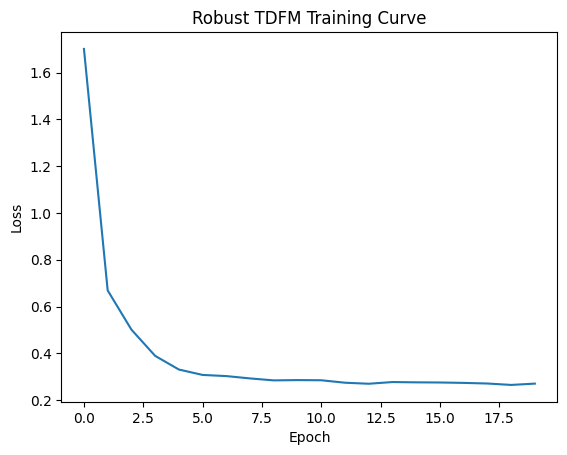


=== Test RMSE Summary (same split, no text leakage) ===
MF baseline: 0.6236
TDFM:        0.5369
MF - TDFM:   0.0867
[TDFM] Saved vocab -> tdfm_vocab.npy


In [10]:
users_all, items_all, ratings_all, reviews_all, exposure_all, meta = prepare_common_tensors(
    csv_path=CSV_PATH,
    confounder_path=CONFOUNDER_PATH,
    max_features=MAX_FEATURES,
    stop_words=STOP_WORDS,
    seed=SEED,
    split_path=SPLIT_PATH,
)

mf_train_loader, mf_test_loader = make_loaders_mf(users_all, items_all, ratings_all, meta, batch_size=BATCH_SIZE)
td_train_loader, td_test_loader = make_loaders_tdfm(users_all, items_all, reviews_all, exposure_all, ratings_all, meta, batch_size=BATCH_SIZE)

mf_rmse, mf_losses, _ = train_mf_from_loaders(
    mf_train_loader, mf_test_loader, meta["n_users"], meta["n_items"],
    emb_dim=EMBEDDING_DIM, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, epochs=EPOCHS, device=DEVICE
)

tdfm_rmse, tdfm_losses, _ = train_tdfm_from_loaders(
    td_train_loader, td_test_loader, meta["n_users"], meta["n_items"], meta["vocab_size"],
    num_topics=NUM_TOPICS, emb_dim=EMBEDDING_DIM, epochs=EPOCHS, lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY, recon_weight=0.002, device=DEVICE, save_path="tdfm_model.pt"
)

print("\n=== Test RMSE Summary (same split, no text leakage) ===")
print(f"MF baseline: {mf_rmse:.4f}")
print(f"TDFM:        {tdfm_rmse:.4f}")
print(f"MF - TDFM:   {mf_rmse - tdfm_rmse:.4f}")

np.save("tdfm_vocab.npy", meta["vocab"])
print("[TDFM] Saved vocab -> tdfm_vocab.npy")


### 6A. Evaluation utilities + bootstrap confidence intervals

We report RMSE/MAE and quantify uncertainty using **paired bootstrap** (and later, **user-block bootstrap** to account for per-user correlation).

In [ ]:
# === Evaluation + stronger stats (paired bootstrap) ===

DEVICE = globals().get("DEVICE", "cuda" if torch.cuda.is_available() else "cpu")

def rmse(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

def mae(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.mean(np.abs(yhat - y)))

def _clip_ratings(x, lo=1.0, hi=5.0):
    return np.clip(np.asarray(x).reshape(-1), lo, hi)

@torch.no_grad()
def predict_mf(model, loader, device=DEVICE):
    model.eval()
    preds, trues = [], []
    for u, i, r in loader:
        u, i = u.to(device), i.to(device)
        yhat = model(u, i).detach().cpu().numpy()
        preds.append(yhat)
        trues.append(r.detach().cpu().numpy())
    return np.concatenate(preds), np.concatenate(trues)

@torch.no_grad()
def predict_tdfm(model, loader, device=DEVICE):
    """
    In THIS notebook, td_* loaders yield: (u, i, bow, exposure, r)
    forward(user_idx, item_idx, bow_input, exposure_val) -> (pred, recon_log_probs)
    """
    model.eval()
    preds, trues = [], []

    expected_vocab = None
    if hasattr(model, "encoder_fc1") and hasattr(model.encoder_fc1, "in_features"):
        expected_vocab = int(model.encoder_fc1.in_features)

    for batch in loader:
        if len(batch) != 5:
            raise ValueError(f"Expected 5-tuple (u,i,bow,exposure,r) from td loader, got {len(batch)}")
        u, i, bow, exposure, r = batch

        # Safety: if bow/exposure were accidentally swapped somewhere, auto-fix by shape
        if expected_vocab is not None:
            if bow.dim() == 1: bow = bow.unsqueeze(1)
            if exposure.dim() == 1: exposure = exposure.unsqueeze(1)

            if bow.shape[1] != expected_vocab and exposure.shape[1] == expected_vocab:
                bow, exposure = exposure, bow  # swap

            assert bow.shape[1] == expected_vocab, (
                f"bow shape {tuple(bow.shape)} but expected (*,{expected_vocab}). "
                "Your td loader order should be (u,i,bow,exposure,r)."
            )
            # exposure can be (B,1) or (B,vocab) depending on how you built it
            assert exposure.shape[1] in (1, expected_vocab), (
                f"exposure shape {tuple(exposure.shape)}; expected (*,1) or (*,{expected_vocab})."
            )

        u, i = u.to(device), i.to(device)
        bow, exposure = bow.to(device), exposure.to(device)

        pred, _ = model(u, i, bow, exposure)
        preds.append(pred.detach().cpu().numpy())
        trues.append(r.detach().cpu().numpy())

    return np.concatenate(preds), np.concatenate(trues)

# ---- grab loaders/meta ----
meta = globals().get("meta", None)
mf_train_loader = globals().get("mf_train_loader", None)
mf_test_loader  = globals().get("mf_test_loader", None)
td_train_loader = globals().get("td_train_loader", None)
td_test_loader  = globals().get("td_test_loader", None)

if meta is None:
    raise NameError("meta not found. Run the data-prep cell that defines `meta` first.")
if mf_test_loader is None or td_test_loader is None:
    raise NameError("mf_test_loader / td_test_loader not found. Run the loader-creation cell first.")

# ---- MF model: use if present, else retrain (since we overwrote `_`) ----
mf_model = globals().get("mf_model", None)
if mf_model is None:
    if "train_mf_from_loaders" in globals() and mf_train_loader is not None:
        print("[eval] mf_model not found; retraining MF baseline so we can evaluate.")
        # train_mf_from_loaders signature: (train_loader, test_loader, n_users, n_items, ...)
        if "meta" in globals() and meta is not None:
            n_users = meta.get("n_users", None)
            n_items = meta.get("n_items", None)
        else:
            n_users = globals().get("n_users", None)
            n_items = globals().get("n_items", None)
        if n_users is None or n_items is None:
            raise NameError("Need n_users and n_items to retrain MF baseline (expected in meta['n_users'], meta['n_items']).")
        _, _, mf_model = train_mf_from_loaders(
            mf_train_loader, mf_test_loader, int(n_users), int(n_items),
            epochs=20, lr=0.01, device=DEVICE
        )
    else:
        raise NameError("mf_model not found and cannot retrain (missing train_mf_from_loaders or mf_train_loader).")

# ---- TDFM model: use if present, else load from disk (you saved tdfm_model.pt) ----
tdfm_model = globals().get("tdfm_model", None)
if tdfm_model is None:
    tdfm_path = Path(globals().get("TDFM_STATE_PATH", "tdfm_model.pt"))
    if not tdfm_path.exists():
        raise NameError("tdfm_model not found in memory and tdfm_model.pt not found. Re-run TDFM training cell.")
    vocab_size = int(meta["vocab_size"])
    num_users  = int(meta["n_users"])
    num_items  = int(meta["n_items"])
    num_topics = int(globals().get("NUM_TOPICS", 10))
    emb_dim    = int(globals().get("EMBEDDING_DIM", 32))

    tdfm_model = TDFM(num_users, num_items, vocab_size, num_topics=num_topics, emb_dim=emb_dim).to(DEVICE)
    tdfm_model.load_state_dict(torch.load(tdfm_path, map_location=DEVICE))
    print(f"[eval] Loaded TDFM from {tdfm_path}")

mf_model = mf_model.to(DEVICE)
tdfm_model = tdfm_model.to(DEVICE)

# ---- metrics ----
mf_pred, y_test = predict_mf(mf_model, mf_test_loader, device=DEVICE)
td_pred, y_test2 = predict_tdfm(tdfm_model, td_test_loader, device=DEVICE)

# sanity check: same test labels
if not np.allclose(y_test, y_test2):
    raise RuntimeError("MF test labels and TDFM test labels differ — check you used the same split indices.")

mf_pred = _clip_ratings(mf_pred)
td_pred = _clip_ratings(td_pred)

print("\n=== Test metrics (same split, no text leakage) ===")
print(f"MF   RMSE: {rmse(mf_pred, y_test):.4f} | MAE: {mae(mf_pred, y_test):.4f}")
print(f"TDFM RMSE: {rmse(td_pred, y_test):.4f} | MAE: {mae(td_pred, y_test):.4f}")
print(f"ΔRMSE (MF - TDFM): {rmse(mf_pred, y_test) - rmse(td_pred, y_test):.4f}")
print(f"ΔMAE  (MF - TDFM): {mae(mf_pred, y_test) - mae(td_pred, y_test):.4f}")

# ---- paired bootstrap CIs (stronger claim) ----
B = 2000
rng = np.random.default_rng(0)
se_mf = (mf_pred - y_test) ** 2
se_td = (td_pred - y_test) ** 2
ae_mf = np.abs(mf_pred - y_test)
ae_td = np.abs(td_pred - y_test)

n = len(y_test)
impr_rmse = np.empty(B, dtype=float)
impr_mae  = np.empty(B, dtype=float)

for b in range(B):
    idx = rng.integers(0, n, size=n)
    impr_rmse[b] = np.sqrt(se_mf[idx].mean()) - np.sqrt(se_td[idx].mean())
    impr_mae[b]  = ae_mf[idx].mean() - ae_td[idx].mean()

lo_r, hi_r = np.percentile(impr_rmse, [2.5, 97.5])
lo_a, hi_a = np.percentile(impr_mae,  [2.5, 97.5])

pct_better_se = float((se_td < se_mf).mean()) * 100.0
pct_better_ae = float((ae_td < ae_mf).mean()) * 100.0

print(f"\nPaired bootstrap 95% CI (B={B})")
print(f"ΔRMSE (MF - TDFM): [{lo_r:.4f}, {hi_r:.4f}]")
print(f"ΔMAE  (MF - TDFM): [{lo_a:.4f}, {hi_a:.4f}]")
print(f"% test points with lower SE under TDFM: {pct_better_se:.1f}%")
print(f"% test points with lower AE under TDFM: {pct_better_ae:.1f}%")

# ---- extra: RMSE by true rating (1..5) ----
print("\nRMSE by true rating:")
for val in [1, 2, 3, 4, 5]:
    mask = (y_test == val)
    if mask.sum() == 0:
        continue
    print(f"  y={val}: MF {rmse(mf_pred[mask], y_test[mask]):.4f} | "
          f"TDFM {rmse(td_pred[mask], y_test[mask]):.4f} | n={mask.sum()}")


[eval] mf_model not found; retraining MF baseline so we can evaluate.
[MF] Epoch 00 | Train MSE: 1.8917
[MF] Epoch 05 | Train MSE: 0.0731
[MF] Epoch 10 | Train MSE: 0.0400
[MF] Epoch 15 | Train MSE: 0.0330
[MF] Final Test RMSE: 0.6234
[eval] Loaded TDFM from tdfm_model.pt

=== Test metrics (same split, no text leakage) ===
MF   RMSE: 0.6234 | MAE: 0.4066
TDFM RMSE: 0.5369 | MAE: 0.3333
ΔRMSE (MF - TDFM): 0.0865
ΔMAE  (MF - TDFM): 0.0733

Paired bootstrap 95% CI (B=2000)
ΔRMSE (MF - TDFM): [0.0613, 0.1131]
ΔMAE  (MF - TDFM): [0.0587, 0.0888]
% test points with lower SE under TDFM: 67.9%
% test points with lower AE under TDFM: 67.9%

RMSE by true rating:
  y=1: MF 3.2532 | TDFM 2.6845 | n=8
  y=2: MF 2.4513 | TDFM 2.3601 | n=18
  y=3: MF 1.5644 | TDFM 1.2905 | n=36
  y=4: MF 0.6348 | TDFM 0.6746 | n=134
  y=5: MF 0.3677 | TDFM 0.2654 | n=1021


In [ ]:
# Metric utilities and batched prediction functions

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Ridge, LogisticRegression

def weighted_rmse(yhat, y, w):
    yhat = np.asarray(yhat).reshape(-1)
    y    = np.asarray(y).reshape(-1)
    w    = np.asarray(w).reshape(-1)
    return float(np.sqrt(np.sum(w * (yhat - y) ** 2) / np.sum(w)))

def weighted_mae(yhat, y, w):
    yhat = np.asarray(yhat).reshape(-1)
    y    = np.asarray(y).reshape(-1)
    w    = np.asarray(w).reshape(-1)
    return float(np.sum(w * np.abs(yhat - y)) / np.sum(w))

@torch.no_grad()
def predict_mf_on_indices(model, users_all, items_all, idx, device=DEVICE, batch_size=8192):
    model.eval()
    idx = np.asarray(idx)
    preds = []
    for s in range(0, len(idx), batch_size):
        b = idx[s:s+batch_size]
        u = users_all[b].to(device)
        i = items_all[b].to(device)
        preds.append(model(u, i).detach().cpu().numpy())
    return np.concatenate(preds)

@torch.no_grad()
def predict_tdfm_on_indices(model, users_all, items_all, reviews_all, exposure_all, idx, device=DEVICE, batch_size=4096):
    """
    forward(u, i, bow, exposure) -> (pred, recon_log_probs)
    """
    model.eval()
    idx = np.asarray(idx)
    preds = []
    for s in range(0, len(idx), batch_size):
        b = idx[s:s+batch_size]
        u = users_all[b].to(device)
        i = items_all[b].to(device)
        bow = reviews_all[b].to(device)
        exp = exposure_all[b].to(device)
        yhat, _ = model(u, i, bow, exp)
        preds.append(yhat.detach().cpu().numpy())
    return np.concatenate(preds)

### 6B. Additional baseline: MF + train-only LDA residual correction

This block fits an LDA-style topic model on **train text only** and tests whether topic residualization improves MF. This is supplementary, and is clearly separated from the main MF vs TDFM comparison.

In [ ]:
# ===== LDA baseline (train-only fit) =====
train_idx = np.asarray(meta["train_idx"])
test_idx  = np.asarray(meta["test_idx"])

# Use the existing BOW counts (reviews_all) and fit LDA ONLY on train
X_bow_all = reviews_all.detach().cpu().numpy()
X_bow_tr  = X_bow_all[train_idx]
X_bow_te  = X_bow_all[test_idx]

NUM_TOPICS_LDA = 10   # you can match NUM_TOPICS in your TDFM
lda = LatentDirichletAllocation(
    n_components=NUM_TOPICS_LDA,
    learning_method="batch",
    random_state=SEED,
    max_iter=30
)
lda.fit(X_bow_tr)

theta_tr = lda.transform(X_bow_tr)  # (n_train, K)
theta_te = lda.transform(X_bow_te)  # (n_test,  K)

# Predictions from MF, aligned to the SAME index order
y_tr = ratings_all[train_idx].detach().cpu().numpy()
y_te = ratings_all[test_idx].detach().cpu().numpy()

yhat_tr_mf = predict_mf_on_indices(mf_model, users_all, items_all, train_idx, device=DEVICE)
yhat_te_mf = predict_mf_on_indices(mf_model, users_all, items_all, test_idx,  device=DEVICE)

# Fit ridge on MF residuals using LDA topic proportions
res_tr = y_tr - yhat_tr_mf
ridge = Ridge(alpha=1.0, random_state=SEED)
ridge.fit(theta_tr, res_tr)

# MF + LDA residual correction
yhat_te_mf_lda = yhat_te_mf + ridge.predict(theta_te)
yhat_te_mf_lda = np.clip(yhat_te_mf_lda, 1.0, 5.0)

print("[LDA baseline] MF+LDA residual correction:")
print("  RMSE:", rmse(yhat_te_mf_lda, y_te))
print("  MAE :", mae(yhat_te_mf_lda, y_te))

[LDA baseline] MF+LDA residual correction:
  RMSE: 0.6123486161231995
  MAE : 0.3348298668861389


In [ ]:
# === Stronger stats: USER-level (block) bootstrap + % users improved ===

# 1) Reconstruct aligned user ids for the test set (same order as mf_pred / y_test)
u_list, r_list = [], []
for batch in mf_test_loader:
    # mf_test_loader yields (u, i, r)
    u, i, r = batch
    u_list.append(u.detach().cpu().numpy().reshape(-1))
    r_list.append(r.detach().cpu().numpy().reshape(-1))

u_test = np.concatenate(u_list)
r_test = np.concatenate(r_list)

# Sanity check: these should match if the loader order is deterministic (shuffle=False)
y_arr = np.asarray(y_test).reshape(-1)
mf_arr = np.asarray(mf_pred).reshape(-1)
td_arr = np.asarray(td_pred).reshape(-1)

assert len(u_test) == len(y_arr) == len(mf_arr) == len(td_arr), "Length mismatch."
if not np.allclose(r_test, y_arr):
    print("[warn] r_test != y_test (likely different ordering). Using r_test as ground truth for this cell.")
    y_arr = r_test

# 2) Precompute per-user sufficient statistics
users = np.unique(u_test)
user_to_pos = {u: j for j, u in enumerate(users)}
m = len(users)

cnt = np.zeros(m, dtype=np.int64)
sse_mf = np.zeros(m, dtype=float)
sse_td = np.zeros(m, dtype=float)
sae_mf = np.zeros(m, dtype=float)
sae_td = np.zeros(m, dtype=float)

se_mf_all = (mf_arr - y_arr) ** 2
se_td_all = (td_arr - y_arr) ** 2
ae_mf_all = np.abs(mf_arr - y_arr)
ae_td_all = np.abs(td_arr - y_arr)

for idx, u in enumerate(u_test):
    j = user_to_pos[int(u)]
    cnt[j] += 1
    sse_mf[j] += float(se_mf_all[idx])
    sse_td[j] += float(se_td_all[idx])
    sae_mf[j] += float(ae_mf_all[idx])
    sae_td[j] += float(ae_td_all[idx])

# 3) User-level "who wins" (each user gets one vote)
rmse_user_mf = np.sqrt(sse_mf / np.maximum(cnt, 1))
rmse_user_td = np.sqrt(sse_td / np.maximum(cnt, 1))
pct_users_better_rmse = 100.0 * float((rmse_user_td < rmse_user_mf).mean())

mae_user_mf = sae_mf / np.maximum(cnt, 1)
mae_user_td = sae_td / np.maximum(cnt, 1)
pct_users_better_mae = 100.0 * float((mae_user_td < mae_user_mf).mean())

# 4) Block bootstrap over users (more conservative than iid-over-observations bootstrap)
B = 2000
rng = np.random.default_rng(0)

impr_rmse = np.empty(B, dtype=float)  # RMSE(MF) - RMSE(TDFM)
impr_mae  = np.empty(B, dtype=float)  # MAE(MF)  - MAE(TDFM)

for b in range(B):
    picks = rng.integers(0, m, size=m)  # sample users with replacement
    cnt_b = cnt[picks].sum()

    # Aggregate back to observation-weighted metrics
    rmse_mf_b = np.sqrt(sse_mf[picks].sum() / cnt_b)
    rmse_td_b = np.sqrt(sse_td[picks].sum() / cnt_b)
    impr_rmse[b] = rmse_mf_b - rmse_td_b

    mae_mf_b = sae_mf[picks].sum() / cnt_b
    mae_td_b = sae_td[picks].sum() / cnt_b
    impr_mae[b] = mae_mf_b - mae_td_b

lo_r, hi_r = np.percentile(impr_rmse, [2.5, 97.5])
lo_a, hi_a = np.percentile(impr_mae,  [2.5, 97.5])

print("\n=== USER-level (block) bootstrap over users ===")
print(f"Users in test: {m}")
print(f"ΔRMSE (MF - TDFM): [{lo_r:.4f}, {hi_r:.4f}]   (B={B})")
print(f"ΔMAE  (MF - TDFM): [{lo_a:.4f}, {hi_a:.4f}]   (B={B})")
print(f"% users with lower RMSE under TDFM: {pct_users_better_rmse:.1f}%")
print(f"% users with lower MAE  under TDFM: {pct_users_better_mae:.1f}%")


=== USER-level (block) bootstrap over users ===
Users in test: 913
ΔRMSE (MF - TDFM): [0.0611, 0.1138]   (B=2000)
ΔMAE  (MF - TDFM): [0.0586, 0.0891]   (B=2000)
% users with lower RMSE under TDFM: 68.6%
% users with lower MAE  under TDFM: 69.6%


RMSE/MAE ablation note (diagnostic vs. fair ablation)

Diagnostic only (not a fair ablation): Removing the topic/text term at inference time while keeping a model trained with that term can produce misleading results (the model is not optimized for that architecture).


Fair ablation:
In Section 8 (Robustness upgrades) we retrain a NoTopic variant and evaluate it on the same aligned test set, with paired and user-block bootstrap deltas.

In [ ]:
# DEVICE = globals().get("DEVICE", "cuda" if torch.cuda.is_available() else "cpu")

# --- helper: clip to rating scale ---
def _clip_1_5(x):
    x = np.asarray(x).reshape(-1)
    return np.clip(x, 1.0, 5.0)

@torch.no_grad()
def predict_tdfm_no_topic(model, loader, device=DEVICE):
    """Compute TDFM predictions with topic term removed: MF backbone + exposure bias only."""
    model.eval()
    preds, trues = [], []

    for batch in loader:
        if len(batch) != 5:
            raise ValueError(f"Expected 5-tuple (u,i,bow,exposure,r), got {len(batch)}")
        u, i, bow, exposure, r = batch
        u, i = u.to(device), i.to(device)
        exposure = exposure.to(device).float()

        # MF part
        ue = model.user_embedding(u)
        ie = model.item_embedding(i)
        interaction = (model.mf_drop(ue) * model.mf_drop(ie)).sum(dim=1, keepdim=True)

        u_b = model.user_bias(u)
        i_b = model.item_bias(i)

        # Exposure term (same as in the full model)
        exp_term = model.exposure_bias(exposure)

        raw = (interaction + u_b + i_b + exp_term).squeeze(1)
        pred = torch.sigmoid(raw) * 4.0 + 1.0

        preds.append(pred.detach().cpu().numpy().reshape(-1))
        trues.append(r.detach().cpu().numpy().reshape(-1))

    return np.concatenate(preds), np.concatenate(trues)

# --- run ablation prediction on the SAME td_test_loader / y_test order ---
td_pred_no_topic, y_test_nt = predict_tdfm_no_topic(tdfm_model.to(DEVICE), td_test_loader, device=DEVICE)

# align / sanity-check
y_test_nt = np.asarray(y_test_nt).reshape(-1)
td_pred_no_topic = _clip_1_5(td_pred_no_topic)

y_arr = np.asarray(y_test).reshape(-1)
assert len(td_pred_no_topic) == len(y_arr) == len(mf_pred) == len(td_pred), "Length mismatch among predictions."
if not np.allclose(y_test_nt, y_arr):
    raise RuntimeError("TDFM-no-topic test labels differ from y_test — check split alignment.")

# --- metrics ---
def rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

def mae_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.mean(np.abs(yhat - y)))

rmse_mf = rmse_np(mf_pred, y_arr)
rmse_td = rmse_np(td_pred, y_arr)
rmse_nt = rmse_np(td_pred_no_topic, y_arr)

mae_mf = mae_np(mf_pred, y_arr)
mae_td = mae_np(td_pred, y_arr)
mae_nt = mae_np(td_pred_no_topic, y_arr)

summary = pd.DataFrame({
    "model": ["MF", "TDFM(full)", "TDFM(no-topic)"],
    "RMSE":  [rmse_mf, rmse_td, rmse_nt],
    "MAE":   [mae_mf,  mae_td,  mae_nt],
    "ΔRMSE vs MF (MF - model)": [0.0, rmse_mf - rmse_td, rmse_mf - rmse_nt],
    "ΔMAE  vs MF (MF - model)": [0.0, mae_mf  - mae_td,  mae_mf  - mae_nt],
})
display(summary)

# --- paired bootstrap CIs (iid over observations) for MF - no-topic AND no-topic - full ---
B = 2000
rng = np.random.default_rng(0)
n = len(y_arr)

se_mf = (np.asarray(mf_pred) - y_arr) ** 2
se_td = (np.asarray(td_pred) - y_arr) ** 2
se_nt = (np.asarray(td_pred_no_topic) - y_arr) ** 2

ae_mf = np.abs(np.asarray(mf_pred) - y_arr)
ae_td = np.abs(np.asarray(td_pred) - y_arr)
ae_nt = np.abs(np.asarray(td_pred_no_topic) - y_arr)

impr_mf_nt_rmse = np.empty(B)
impr_mf_nt_mae  = np.empty(B)
impr_nt_td_rmse = np.empty(B)
impr_nt_td_mae  = np.empty(B)

for b in range(B):
    idx = rng.integers(0, n, size=n)

    # MF - no-topic
    impr_mf_nt_rmse[b] = np.sqrt(se_mf[idx].mean()) - np.sqrt(se_nt[idx].mean())
    impr_mf_nt_mae[b]  = ae_mf[idx].mean() - ae_nt[idx].mean()

    # no-topic - full TDFM (positive means full TDFM better)
    impr_nt_td_rmse[b] = np.sqrt(se_nt[idx].mean()) - np.sqrt(se_td[idx].mean())
    impr_nt_td_mae[b]  = ae_nt[idx].mean() - ae_td[idx].mean()

lo1, hi1 = np.percentile(impr_mf_nt_rmse, [2.5, 97.5])
lo2, hi2 = np.percentile(impr_mf_nt_mae,  [2.5, 97.5])
lo3, hi3 = np.percentile(impr_nt_td_rmse, [2.5, 97.5])
lo4, hi4 = np.percentile(impr_nt_td_mae,  [2.5, 97.5])

print(f"\nPaired bootstrap 95% CI (B={B})")
print(f"ΔRMSE (MF - no-topic): [{lo1:.4f}, {hi1:.4f}]")
print(f"ΔMAE  (MF - no-topic): [{lo2:.4f}, {hi2:.4f}]")
print(f"ΔRMSE (no-topic - full): [{lo3:.4f}, {hi3:.4f}]  ( >0 means full TDFM better )")
print(f"ΔMAE  (no-topic - full): [{lo4:.4f}, {hi4:.4f}]  ( >0 means full TDFM better )")

# --- USER-level (block) bootstrap for MF - no-topic (uses u_test from prior cell) ---
if "u_test" in globals():
    u_test_arr = np.asarray(u_test).reshape(-1).astype(int)
    users = np.unique(u_test_arr)
    user_to_pos = {u: j for j, u in enumerate(users)}
    m = len(users)

    cnt = np.zeros(m, dtype=np.int64)
    sse_mf_u = np.zeros(m, dtype=float)
    sse_nt_u = np.zeros(m, dtype=float)
    sae_mf_u = np.zeros(m, dtype=float)
    sae_nt_u = np.zeros(m, dtype=float)

    se_mf_all = (np.asarray(mf_pred) - y_arr) ** 2
    se_nt_all = (np.asarray(td_pred_no_topic) - y_arr) ** 2
    ae_mf_all = np.abs(np.asarray(mf_pred) - y_arr)
    ae_nt_all = np.abs(np.asarray(td_pred_no_topic) - y_arr)

    for idx, u in enumerate(u_test_arr):
        j = user_to_pos[int(u)]
        cnt[j] += 1
        sse_mf_u[j] += float(se_mf_all[idx])
        sse_nt_u[j] += float(se_nt_all[idx])
        sae_mf_u[j] += float(ae_mf_all[idx])
        sae_nt_u[j] += float(ae_nt_all[idx])

    rmse_user_mf = np.sqrt(sse_mf_u / np.maximum(cnt, 1))
    rmse_user_nt = np.sqrt(sse_nt_u / np.maximum(cnt, 1))
    pct_users_better_rmse = 100.0 * float((rmse_user_nt < rmse_user_mf).mean())

    mae_user_mf = sae_mf_u / np.maximum(cnt, 1)
    mae_user_nt = sae_nt_u / np.maximum(cnt, 1)
    pct_users_better_mae = 100.0 * float((mae_user_nt < mae_user_mf).mean())

    B = 2000
    rng = np.random.default_rng(0)
    impr_rmse = np.empty(B, dtype=float)
    impr_mae  = np.empty(B, dtype=float)

    for b in range(B):
        picks = rng.integers(0, m, size=m)
        cnt_b = cnt[picks].sum()
        if cnt_b <= 0:
            impr_rmse[b] = np.nan
            impr_mae[b] = np.nan
            continue
        rmse_mf_b = np.sqrt(sse_mf_u[picks].sum() / cnt_b)
        rmse_nt_b = np.sqrt(sse_nt_u[picks].sum() / cnt_b)
        impr_rmse[b] = rmse_mf_b - rmse_nt_b

        mae_mf_b = sae_mf_u[picks].sum() / cnt_b
        mae_nt_b = sae_nt_u[picks].sum() / cnt_b
        impr_mae[b] = mae_mf_b - mae_nt_b

    lo_r, hi_r = np.nanpercentile(impr_rmse, [2.5, 97.5])
    lo_a, hi_a = np.nanpercentile(impr_mae,  [2.5, 97.5])

    print("\n=== USER-level (block) bootstrap over users (MF - no-topic) ===")
    print(f"Users in test: {m}")
    print(f"ΔRMSE (MF - no-topic): [{lo_r:.4f}, {hi_r:.4f}]   (B={B})")
    print(f"ΔMAE  (MF - no-topic): [{lo_a:.4f}, {hi_a:.4f}]   (B={B})")
    print(f"% users with lower RMSE under no-topic: {pct_users_better_rmse:.1f}%")
    print(f"% users with lower MAE  under no-topic: {pct_users_better_mae:.1f}%")
else:
    print("[info] u_test not found (run the USER-level bootstrap cell above to enable block bootstrap here).")


,model,RMSE,MAE,ΔRMSE vs MF (MF - model),ΔMAE vs MF (MF - model)
0,MF,0.623414,0.406632,0.000000,0.000000
1,TDFM(full),0.536871,0.333324,0.086543,0.073308
2,TDFM(no-topic),1.128185,1.023357,-0.504771,-0.616725



Paired bootstrap 95% CI (B=2000)
ΔRMSE (MF - no-topic): [-0.5595, -0.4501]
ΔMAE  (MF - no-topic): [-0.6486, -0.5850]
ΔRMSE (no-topic - full): [0.5418, 0.6451]  ( >0 means full TDFM better )
ΔMAE  (no-topic - full): [0.6589, 0.7215]  ( >0 means full TDFM better )

=== USER-level (block) bootstrap over users (MF - no-topic) ===
Users in test: 913
ΔRMSE (MF - no-topic): [-0.5601, -0.4502]   (B=2000)
ΔMAE  (MF - no-topic): [-0.6486, -0.5836]   (B=2000)
% users with lower RMSE under no-topic: 12.7%
% users with lower MAE  under no-topic: 12.3%


Here we add:

- Ranking metrics: Recall@K and NDCG@K with negative sampling (sweep over N_neg and K)
- Slice evaluations: item popularity bins + user history length bins

Ablations for ranking:
- NoTopic_trained (fair): retrain a model without the topic/text term, same split and training setup
- TDFM_obs_no_topic (diagnostic, drop-at-inference): use the full trained TDFM model but omit the topic term at scoring time (keep MF backbone + exposure term)

In [ ]:
from collections import defaultdict

# ===== 0) checks =====
_required = ["mf_train_loader", "mf_test_loader", "td_train_loader", "mf_pred", "td_pred", "y_test", "mf_model", "tdfm_model", "meta"]
_missing = [k for k in _required if k not in globals()]
if _missing:
    raise NameError(f"Missing variables needed for ranking/slice eval: {_missing}")

# ===== 1) reconstruct aligned (user,item,rating) for the MF test loader order =====
u_list, i_list, r_list = [], [], []
for (u, it, r) in mf_test_loader:  # yields (u, i, r)
    u_list.append(u.detach().cpu().numpy().reshape(-1))
    i_list.append(it.detach().cpu().numpy().reshape(-1))
    r_list.append(r.detach().cpu().numpy().reshape(-1))

u_test = np.concatenate(u_list)
i_test = np.concatenate(i_list)
r_test = np.concatenate(r_list)

y_arr = np.asarray(y_test).reshape(-1)
mf_arr = np.asarray(mf_pred).reshape(-1)
td_arr = np.asarray(td_pred).reshape(-1)

assert len(y_arr) == len(u_test) == len(i_test) == len(mf_arr) == len(td_arr), "Misaligned test arrays."
if not np.allclose(r_test, y_arr):
    print("[warn] mf_test_loader ratings != y_test order. Using r_test as ground truth in this section.")
    y_arr = r_test

test_df = pd.DataFrame({
    "user_id": u_test.astype(int),
    "item_id": i_test.astype(int),
    "rating":  y_arr.astype(float),
    "mf_pred": mf_arr.astype(float),
    "td_pred": td_arr.astype(float),
})

# ===== 2) train interaction sets + popularity/history counts =====
n_users = int(meta["n_users"])
n_items = int(meta["n_items"])

train_user_items = defaultdict(set)
item_pop = np.zeros(n_items, dtype=np.int64)
user_hist = np.zeros(n_users, dtype=np.int64)

for (u, it, r) in mf_train_loader:
    uu = u.detach().cpu().numpy().astype(int).reshape(-1)
    ii = it.detach().cpu().numpy().astype(int).reshape(-1)
    for a, b in zip(uu, ii):
        train_user_items[a].add(b)
    item_pop[ii] += 1
    user_hist[uu] += 1

# ===== 3) define bins (0 + quantiles among nonzero) =====
def _make_quantile_edges(x_nonneg, qs):
    x = np.asarray(x_nonneg)
    x_nz = x[x > 0]
    if len(x_nz) == 0:
        return np.array([0.0, 1.0], dtype=float)
    edges = np.unique(np.quantile(x_nz, qs))
    edges = np.concatenate(([0.0], edges))
    return edges

pop_edges  = _make_quantile_edges(item_pop,  qs=[0.2, 0.6, 0.9, 1.0])
hist_edges = _make_quantile_edges(user_hist, qs=[0.2, 0.6, 0.9, 1.0])

pop_labels  = [f"pop_bin_{k}"  for k in range(len(pop_edges) - 1)]
hist_labels = [f"hist_bin_{k}" for k in range(len(hist_edges) - 1)]

def assign_bin(x, edges, labels):
    j = np.searchsorted(edges, x, side="right") - 1
    j = np.clip(j, 0, len(labels) - 1)
    return labels[j]

item_pop_bin  = np.array([assign_bin(c, pop_edges,  pop_labels)  for c in item_pop], dtype=object)
user_hist_bin = np.array([assign_bin(c, hist_edges, hist_labels) for c in user_hist], dtype=object)

test_df["item_pop_bin"]  = item_pop_bin[test_df["item_id"].values]
test_df["user_hist_bin"] = user_hist_bin[test_df["user_id"].values]

print("test_df:", test_df.shape, "| unique users:", test_df.user_id.nunique(), "| unique items:", test_df.item_id.nunique())
test_df.head()

test_df: (1217, 7) | unique users: 913 | unique items: 100


,user_id,item_id,rating,mf_pred,td_pred,item_pop_bin,user_hist_bin
0,1405,7,5.0,4.857408,4.793510,pop_bin_1,hist_bin_1
1,100,51,5.0,4.841021,4.549818,pop_bin_0,hist_bin_3
2,700,46,4.0,4.790134,4.821331,pop_bin_3,hist_bin_1
3,1552,22,5.0,4.794485,4.863258,pop_bin_1,hist_bin_2
4,143,57,5.0,4.833173,4.732249,pop_bin_1,hist_bin_3


In [ ]:
DEVICE = globals().get("DEVICE", "cuda" if torch.cuda.is_available() else "cpu")

mf_model.eval()
tdfm_model.eval()
mf_model.to(DEVICE)
tdfm_model.to(DEVICE)

# ===== 4) TRAIN-only item-topic profiles (avoid test text leakage) =====
K_topics = int(tdfm_model.topic_bias.weight.shape[1])  # num_topics
theta_sum = np.zeros((n_items, K_topics), dtype=np.float64)
theta_cnt = np.zeros(n_items, dtype=np.int64)

@torch.no_grad()
def infer_theta_from_bow(bow_batch: torch.Tensor) -> torch.Tensor:
    # matches TDFM encoder path; dropout disabled because model.eval()
    h = F.relu(tdfm_model.encoder_fc1(bow_batch))
    h = tdfm_model.encoder_drop(h)
    mu = tdfm_model.encoder_fc2(h)
    theta = F.softmax(mu, dim=1)
    return theta

for batch in td_train_loader:
    # expected: (u, i, bow, exposure, r)
    u, it, bow, exposure, r = batch
    it  = it.to(DEVICE)
    bow = bow.to(DEVICE).float()

    theta = infer_theta_from_bow(bow)  # (B, K)
    it_np = it.detach().cpu().numpy().astype(int).reshape(-1)
    th_np = theta.detach().cpu().numpy()

    for idx, item_id in enumerate(it_np):
        theta_sum[item_id] += th_np[idx]
        theta_cnt[item_id] += 1

item_theta = theta_sum / np.maximum(theta_cnt[:, None], 1)
unif = np.ones(K_topics, dtype=np.float64) / K_topics
item_theta[theta_cnt == 0] = unif

w_topic = tdfm_model.topic_bias.weight.detach().cpu().numpy().reshape(-1)  # (K,)
item_topic_term = item_theta @ w_topic  # (n_items,)

print("item_topic_term computed:", item_topic_term.shape, "| unseen items:", int((theta_cnt == 0).sum()))

item_topic_term computed: (100,) | unseen items: 0


### 6C. Ranking evaluation (Recall@K / NDCG@K) with negative sampling

We evaluate top-K recommendation quality using negative sampling. We sweep `N_NEG` and `K`, and compute bootstrap CIs. Scoring uses the same trained models and (when available) the same exposure proxy used during training.

In [ ]:
import math
from typing import List

# ===== 5) Ranking metrics with negative sampling (fixed: deconfounded ranking + true exposure) =====
SEED = int(globals().get("SEED", 0))
rng = np.random.default_rng(SEED)

def recall_at_k(ranked_items: List[int], pos_set: set, k: int) -> float:
    if len(pos_set) == 0:
        return np.nan
    topk = set(ranked_items[:k])
    return len(topk & pos_set) / len(pos_set)

def ndcg_at_k(ranked_items: List[int], pos_set: set, k: int) -> float:
    if len(pos_set) == 0:
        return np.nan
    dcg = 0.0
    for rank, it in enumerate(ranked_items[:k], start=1):
        if it in pos_set:
            dcg += 1.0 / math.log2(rank + 1)
    ideal_hits = min(len(pos_set), k)
    idcg = sum((1.0 / math.log2(r + 1) for r in range(1, ideal_hits + 1)))
    return dcg / idcg if idcg > 0 else np.nan

DEVICE = globals().get("DEVICE", "cuda" if torch.cuda.is_available() else "cpu")
mf_model.eval(); mf_model.to(DEVICE)
tdfm_model.eval(); tdfm_model.to(DEVICE)

# ---- Load exposure matrix Z_hat (same object used in TDFM training) ----
_exposure_matrix = globals().get("exposure_matrix", None)
if _exposure_matrix is None:
    _path = None
    if "CONFOUNDER_PATH" in globals():
        _path = CONFOUNDER_PATH
    elif "confounder_path" in globals():
        _path = confounder_path
    if _path is None:
        raise RuntimeError("Cannot find CONFOUNDER_PATH / confounder_path to load exposure_matrix for ranking eval.")
    _conf_obj = torch.load(_path, map_location="cpu")
    if isinstance(_conf_obj, dict) and ("Z_hat" in _conf_obj):
        _exposure_matrix = _conf_obj["Z_hat"]
    else:
        _exposure_matrix = _conf_obj
    if not torch.is_tensor(_exposure_matrix):
        _exposure_matrix = torch.tensor(_exposure_matrix)
    exposure_matrix = _exposure_matrix.float().cpu()
else:
    exposure_matrix = _exposure_matrix.float().cpu()

print("exposure_matrix:", tuple(exposure_matrix.shape), "min/max:", float(exposure_matrix.min()), float(exposure_matrix.max()))

def get_exposure_vec(user_id: int, item_ids: np.ndarray) -> np.ndarray:
    u = int(user_id)
    it = torch.tensor(item_ids, dtype=torch.long)
    return exposure_matrix[u, it].numpy().reshape(-1)

@torch.no_grad()
def score_mf(user_id: int, item_ids: np.ndarray) -> np.ndarray:
    u = torch.full((len(item_ids),), int(user_id), device=DEVICE, dtype=torch.long)
    it = torch.tensor(item_ids, device=DEVICE, dtype=torch.long)
    return mf_model(u, it).detach().cpu().numpy().reshape(-1)

@torch.no_grad()
def score_tdfm_pref(user_id: int, item_ids: np.ndarray) -> np.ndarray:
    """Deconfounded preference score for ranking: user/item MF + biases only."""
    u = torch.full((len(item_ids),), int(user_id), device=DEVICE, dtype=torch.long)
    it = torch.tensor(item_ids, device=DEVICE, dtype=torch.long)

    ue = tdfm_model.user_embedding(u)
    ie = tdfm_model.item_embedding(it)

    # IMPORTANT: for ranking, do NOT include exposure/topic (confounding) terms
    interaction = (ue * ie).sum(dim=1, keepdim=True)

    u_b = tdfm_model.user_bias(u)
    i_b = tdfm_model.item_bias(it)

    raw = (interaction + u_b + i_b).squeeze(1)
    pred = torch.sigmoid(raw) * 4.0 + 1.0
    return pred.detach().cpu().numpy().reshape(-1)

@torch.no_grad()
def score_tdfm_observed(user_id: int, item_ids: np.ndarray, exposure_vec: np.ndarray, *, use_topic: bool = True) -> np.ndarray:
    """Observed-rating predictor for ranking: preference + exposure (+ optional topic term)."""
    u = torch.full((len(item_ids),), int(user_id), device=DEVICE, dtype=torch.long)
    it = torch.tensor(item_ids, device=DEVICE, dtype=torch.long)

    ue = tdfm_model.user_embedding(u)
    ie = tdfm_model.item_embedding(it)
    interaction = (ue * ie).sum(dim=1, keepdim=True)

    u_b = tdfm_model.user_bias(u)
    i_b = tdfm_model.item_bias(it)

    exp = torch.tensor(exposure_vec, device=DEVICE, dtype=torch.float32).view(-1, 1)
    exp_term = tdfm_model.exposure_bias(exp)

    if use_topic:
        topic_term = torch.tensor(item_topic_term[item_ids], device=DEVICE, dtype=torch.float32).view(-1, 1)
    else:
        topic_term = torch.zeros((len(item_ids), 1), device=DEVICE, dtype=torch.float32)

    raw = (interaction + u_b + i_b + exp_term + topic_term).squeeze(1)
    pred = torch.sigmoid(raw) * 4.0 + 1.0
    return pred.detach().cpu().numpy().reshape(-1)

def sample_negatives_for_user(user_id: int, pos_items: np.ndarray, n_neg: int) -> np.ndarray:
    banned = set(train_user_items.get(int(user_id), set()))
    banned |= set(map(int, pos_items.tolist()))
    pool = np.setdiff1d(np.arange(n_items, dtype=int), np.fromiter(banned, dtype=int), assume_unique=False)

    if len(pool) == 0:
        return np.array([], dtype=int)

    if len(pool) >= n_neg:
        return rng.choice(pool, size=n_neg, replace=False)
    return rng.choice(pool, size=n_neg, replace=True)

# ---- define positives from explicit ratings ----
POS_THRESH = 4.0
K = 10
N_NEG = 100

pos_df = test_df[test_df["rating"] >= POS_THRESH]
user_to_pos = pos_df.groupby("user_id")["item_id"].apply(lambda x: x.values.astype(int)).to_dict()
users_eval = sorted(user_to_pos.keys())
print("Users with >=1 positive in test:", len(users_eval))

mf_recalls, mf_ndcgs = [], []
td_pref_recalls, td_pref_ndcgs = [], []
td_obs_recalls, td_obs_ndcgs = [], []
td_obs_notopic_recalls, td_obs_notopic_ndcgs = [], []

# slice bookkeeping by item popularity bins (count per-positive hit)
bin_total_pos = {b: 0 for b in pop_labels}
bin_hit_mf = {b: 0 for b in pop_labels}
bin_hit_pref = {b: 0 for b in pop_labels}
bin_hit_obs = {b: 0 for b in pop_labels}
bin_hit_obs_notopic = {b: 0 for b in pop_labels}

for u in users_eval:
    pos_items = user_to_pos[u]
    neg_items = sample_negatives_for_user(u, pos_items, N_NEG)
    cand = np.unique(np.concatenate([pos_items, neg_items])).astype(int)

    exp_vec = get_exposure_vec(u, cand)

    # scores
    s_mf = score_mf(u, cand)
    s_pref = score_tdfm_pref(u, cand)
    s_obs = score_tdfm_observed(u, cand, exp_vec, use_topic=True)
    s_obs_nt = score_tdfm_observed(u, cand, exp_vec, use_topic=False)  # ablation: remove topic term only

    # ranks (desc)
    rank_mf = cand[np.argsort(-s_mf)]
    rank_pref = cand[np.argsort(-s_pref)]
    rank_obs = cand[np.argsort(-s_obs)]
    rank_obs_nt = cand[np.argsort(-s_obs_nt)]

    pos_set = set(map(int, pos_items.tolist()))

    mf_recalls.append(recall_at_k(rank_mf.tolist(), pos_set, K))
    mf_ndcgs.append(ndcg_at_k(rank_mf.tolist(), pos_set, K))

    td_pref_recalls.append(recall_at_k(rank_pref.tolist(), pos_set, K))
    td_pref_ndcgs.append(ndcg_at_k(rank_pref.tolist(), pos_set, K))

    td_obs_recalls.append(recall_at_k(rank_obs.tolist(), pos_set, K))
    td_obs_ndcgs.append(ndcg_at_k(rank_obs.tolist(), pos_set, K))

    td_obs_notopic_recalls.append(recall_at_k(rank_obs_nt.tolist(), pos_set, K))
    td_obs_notopic_ndcgs.append(ndcg_at_k(rank_obs_nt.tolist(), pos_set, K))

    # item popularity bin hit counting (per positive)
    top_mf = set(rank_mf[:K].tolist())
    top_pref = set(rank_pref[:K].tolist())
    top_obs = set(rank_obs[:K].tolist())
    top_obs_nt = set(rank_obs_nt[:K].tolist())

    for it in pos_items:
        b = item_pop_bin[int(it)]
        bin_total_pos[b] += 1
        if int(it) in top_mf: bin_hit_mf[b] += 1
        if int(it) in top_pref: bin_hit_pref[b] += 1
        if int(it) in top_obs: bin_hit_obs[b] += 1
        if int(it) in top_obs_nt: bin_hit_obs_notopic[b] += 1

def _mean(x):
    x = np.asarray(x, dtype=float)
    return float(np.nanmean(x)) if np.isfinite(x).any() else np.nan

results = pd.DataFrame({
    "model": ["MF", "TDFM_pref(deconfounded)", "TDFM_observed", "TDFM_observed(no-topic)"],
    f"Recall@{K}": [
        _mean(mf_recalls),
        _mean(td_pref_recalls),
        _mean(td_obs_recalls),
        _mean(td_obs_notopic_recalls),
    ],
    f"NDCG@{K}": [
        _mean(mf_ndcgs),
        _mean(td_pref_ndcgs),
        _mean(td_obs_ndcgs),
        _mean(td_obs_notopic_ndcgs),
    ],
})
display(results)

pop_table = pd.DataFrame({
    "pop_bin": pop_labels,
    "n_pos":   [bin_total_pos[b] for b in pop_labels],
    f"MF_Recall@{K}": [bin_hit_mf[b] / bin_total_pos[b] if bin_total_pos[b] > 0 else np.nan for b in pop_labels],
    f"Pref_Recall@{K}": [bin_hit_pref[b] / bin_total_pos[b] if bin_total_pos[b] > 0 else np.nan for b in pop_labels],
    f"Obs_Recall@{K}": [bin_hit_obs[b] / bin_total_pos[b] if bin_total_pos[b] > 0 else np.nan for b in pop_labels],
    f"ObsNoTopic_Recall@{K}": [bin_hit_obs_notopic[b] / bin_total_pos[b] if bin_total_pos[b] > 0 else np.nan for b in pop_labels],
})
display(pop_table)

# ---- Quick sanity check ----
DEBUG = False
if DEBUG and len(users_eval) > 0:
    u0 = users_eval[0]
    pos_items0 = user_to_pos[u0]
    neg_items0 = sample_negatives_for_user(u0, pos_items0, 50)
    cand0 = np.unique(np.concatenate([pos_items0, neg_items0])).astype(int)
    exp0 = get_exposure_vec(u0, cand0)

    s0_mf = score_mf(u0, cand0)
    s0_pref = score_tdfm_pref(u0, cand0)
    s0_obs = score_tdfm_observed(u0, cand0, exp0, use_topic=True)

    print("MF std/min/max:", float(np.std(s0_mf)), float(np.min(s0_mf)), float(np.max(s0_mf)))
    print("TDFM_pref std/min/max:", float(np.std(s0_pref)), float(np.min(s0_pref)), float(np.max(s0_pref)))
    print("TDFM_obs std/min/max:", float(np.std(s0_obs)), float(np.min(s0_obs)), float(np.max(s0_obs)))
    print("Exposure min/max/mean:", float(np.min(exp0)), float(np.max(exp0)), float(np.mean(exp0)))

exposure_matrix: (2021, 100) min/max: 8.098121478949949e-11 2.194410800933838
Users with >=1 positive in test: 875


,model,Recall@10,NDCG@10
0,MF,0.370501,0.251260
1,TDFM_pref(deconfounded),0.275652,0.152889
2,TDFM_observed,0.373091,0.240477
3,TDFM_observed(no-topic),0.438329,0.278010


,pop_bin,n_pos,MF_Recall@10,Pref_Recall@10,Obs_Recall@10,ObsNoTopic_Recall@10
0,pop_bin_0,105,0.171429,0.161905,0.190476,0.180952
1,pop_bin_1,275,0.170909,0.163636,0.192727,0.247273
2,pop_bin_2,403,0.250620,0.213400,0.327543,0.389578
3,pop_bin_3,372,0.629032,0.411290,0.561828,0.637097


In [ ]:
# ===== 6) User-history slices for ranking metrics (aligned with fixed ranking eval) =====
user_bin = {u: user_hist_bin[int(u)] for u in users_eval}

slice_rows = []
for b in hist_labels:
    idx = [j for j, u in enumerate(users_eval) if user_bin[u] == b]
    if len(idx) == 0:
        continue
    slice_rows.append({
        "user_hist_bin": b,
        "n_users": len(idx),

        f"MF_Recall@{K}": float(np.nanmean(np.asarray(mf_recalls)[idx])),
        f"Pref_Recall@{K}": float(np.nanmean(np.asarray(td_pref_recalls)[idx])),
        f"Obs_Recall@{K}": float(np.nanmean(np.asarray(td_obs_recalls)[idx])),
        f"ObsNoTopic_Recall@{K}": float(np.nanmean(np.asarray(td_obs_notopic_recalls)[idx])),

        f"MF_NDCG@{K}": float(np.nanmean(np.asarray(mf_ndcgs)[idx])),
        f"Pref_NDCG@{K}": float(np.nanmean(np.asarray(td_pref_ndcgs)[idx])),
        f"Obs_NDCG@{K}": float(np.nanmean(np.asarray(td_obs_ndcgs)[idx])),
        f"ObsNoTopic_NDCG@{K}": float(np.nanmean(np.asarray(td_obs_notopic_ndcgs)[idx])),
    })

slice_df = pd.DataFrame(slice_rows)
display(slice_df)

,user_hist_bin,n_users,MF_Recall@10,Pref_Recall@10,Obs_Recall@10,ObsNoTopic_Recall@10,MF_NDCG@10,Pref_NDCG@10,Obs_NDCG@10,ObsNoTopic_NDCG@10
0,hist_bin_0,62,0.241935,0.147849,0.293011,0.365591,0.130459,0.076454,0.179167,0.210805
1,hist_bin_1,396,0.412668,0.298611,0.391625,0.473274,0.298100,0.167378,0.252072,0.300529
2,hist_bin_2,243,0.368999,0.327503,0.388546,0.450274,0.237819,0.184024,0.262436,0.302417
3,hist_bin_3,174,0.322441,0.196524,0.337863,0.368035,0.206472,0.103668,0.205269,0.216621


In [ ]:
# ===== 7) Rating-metric slices (RMSE/MAE by bins) =====
def rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

def mae_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.mean(np.abs(yhat - y)))

def slice_rating_metrics(df, slice_col):
    rows = []
    for key, g in df.groupby(slice_col):
        rows.append({
            slice_col: key,
            "n": len(g),
            "MF_RMSE": rmse_np(g["mf_pred"], g["rating"]),
            "TDFM_RMSE": rmse_np(g["td_pred"], g["rating"]),
            "ΔRMSE(MF-TDFM)": rmse_np(g["mf_pred"], g["rating"]) - rmse_np(g["td_pred"], g["rating"]),
            "MF_MAE": mae_np(g["mf_pred"], g["rating"]),
            "TDFM_MAE": mae_np(g["td_pred"], g["rating"]),
            "ΔMAE(MF-TDFM)": mae_np(g["mf_pred"], g["rating"]) - mae_np(g["td_pred"], g["rating"]),
        })
    return pd.DataFrame(rows).sort_values("n", ascending=False)

display(slice_rating_metrics(test_df, "item_pop_bin"))
display(slice_rating_metrics(test_df, "user_hist_bin"))

,item_pop_bin,n,MF_RMSE,TDFM_RMSE,ΔRMSE(MF-TDFM),MF_MAE,TDFM_MAE,ΔMAE(MF-TDFM)
2,pop_bin_2,426,0.639145,0.529199,0.109946,0.447106,0.349512,0.097593
3,pop_bin_3,387,0.520572,0.484753,0.035819,0.295683,0.255110,0.040573
1,pop_bin_1,289,0.657267,0.550550,0.106717,0.447327,0.368843,0.078484
0,pop_bin_0,115,0.775911,0.678473,0.097437,0.527801,0.447307,0.080495


,user_hist_bin,n,MF_RMSE,TDFM_RMSE,ΔRMSE(MF-TDFM),MF_MAE,TDFM_MAE,ΔMAE(MF-TDFM)
1,hist_bin_1,444,0.498156,0.462097,0.036059,0.352232,0.304418,0.047814
3,hist_bin_3,338,0.579923,0.445928,0.133995,0.379854,0.300440,0.079413
2,hist_bin_2,317,0.703659,0.570293,0.133366,0.447950,0.354242,0.093708
0,hist_bin_0,118,0.883787,0.851998,0.031789,0.577029,0.480088,0.096941



===== SEED 0 =====
[MF] Epoch 00 | Train MSE: 1.9027
[MF] Epoch 05 | Train MSE: 0.0749
[MF] Epoch 10 | Train MSE: 0.0403
[MF] Epoch 15 | Train MSE: 0.0314
[MF] Final Test RMSE: 0.6260

Starting Robust TDFM Training...
[TDFM] Epoch 00 | Loss=1.7168 | MSE=1.5157
[TDFM] Epoch 05 | Loss=0.3076 | MSE=0.1119
[TDFM] Epoch 10 | Loss=0.2674 | MSE=0.0733
[TDFM] Epoch 15 | Loss=0.2696 | MSE=0.0749

Sample Predictions vs Actuals:
Pred: [4.8626003 4.6299314 4.8177    4.86901   4.7620544]
True: [5. 5. 4. 5. 5.]

[TDFM] Final Test RMSE: 0.5289
[TDFM] Saved model -> .\tdfm_model_seed0.pt


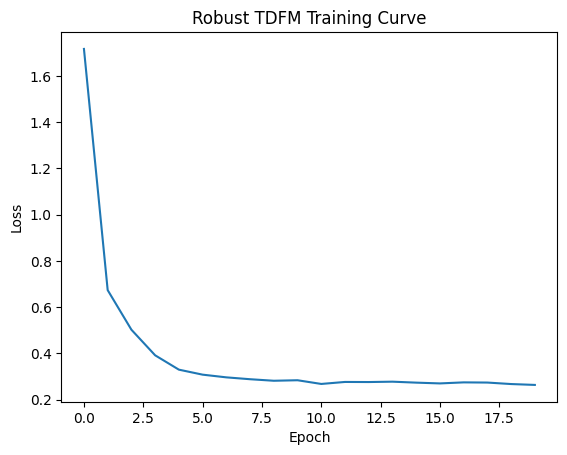

MF   RMSE=0.6260  MAE=0.4071
TDFM RMSE=0.5289  MAE=0.3360
ΔRMSE (MF-TDFM)=0.0972   ΔMAE (MF-TDFM)=0.0711   time=19.3s
Saved TDFM -> .\tdfm_model_seed0.pt

===== SEED 1 =====
[MF] Epoch 00 | Train MSE: 1.9002
[MF] Epoch 05 | Train MSE: 0.0745
[MF] Epoch 10 | Train MSE: 0.0376
[MF] Epoch 15 | Train MSE: 0.0316
[MF] Final Test RMSE: 0.6393

Starting Robust TDFM Training...
[TDFM] Epoch 00 | Loss=1.7014 | MSE=1.5012
[TDFM] Epoch 05 | Loss=0.3028 | MSE=0.1054
[TDFM] Epoch 10 | Loss=0.2801 | MSE=0.0865
[TDFM] Epoch 15 | Loss=0.2691 | MSE=0.0761

Sample Predictions vs Actuals:
Pred: [4.820733  4.7357273 4.829178  4.8427706 4.86367  ]
True: [5. 5. 4. 5. 5.]

[TDFM] Final Test RMSE: 0.5499
[TDFM] Saved model -> .\tdfm_model_seed1.pt


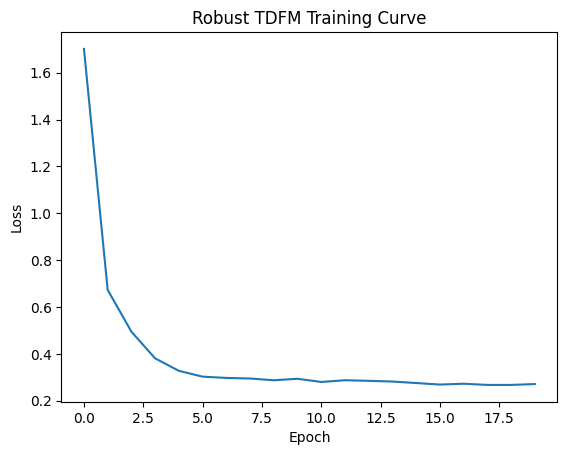

MF   RMSE=0.6393  MAE=0.4140
TDFM RMSE=0.5499  MAE=0.3430
ΔRMSE (MF-TDFM)=0.0894   ΔMAE (MF-TDFM)=0.0709   time=20.4s
Saved TDFM -> .\tdfm_model_seed1.pt

===== SEED 2 =====
[MF] Epoch 00 | Train MSE: 1.8939
[MF] Epoch 05 | Train MSE: 0.0749
[MF] Epoch 10 | Train MSE: 0.0414
[MF] Epoch 15 | Train MSE: 0.0337
[MF] Final Test RMSE: 0.6225

Starting Robust TDFM Training...
[TDFM] Epoch 00 | Loss=1.7062 | MSE=1.5050
[TDFM] Epoch 05 | Loss=0.3123 | MSE=0.1157
[TDFM] Epoch 10 | Loss=0.2782 | MSE=0.0843
[TDFM] Epoch 15 | Loss=0.2709 | MSE=0.0767

Sample Predictions vs Actuals:
Pred: [4.818203  4.7376757 4.8155804 4.893303  4.7631426]
True: [5. 5. 4. 5. 5.]

[TDFM] Final Test RMSE: 0.5274
[TDFM] Saved model -> .\tdfm_model_seed2.pt


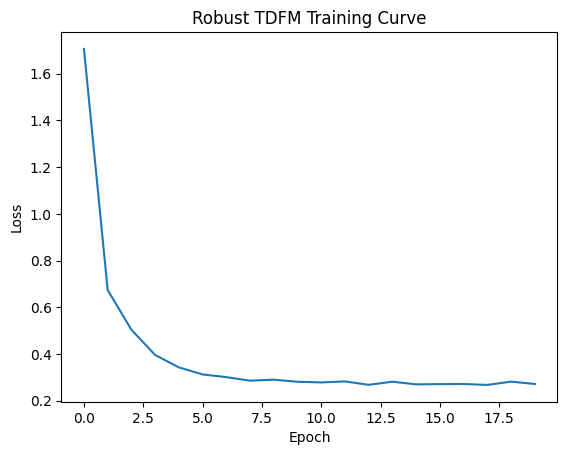

MF   RMSE=0.6225  MAE=0.4067
TDFM RMSE=0.5274  MAE=0.3330
ΔRMSE (MF-TDFM)=0.0950   ΔMAE (MF-TDFM)=0.0737   time=20.7s
Saved TDFM -> .\tdfm_model_seed2.pt

===== SEED 3 =====
[MF] Epoch 00 | Train MSE: 1.9039
[MF] Epoch 05 | Train MSE: 0.0735
[MF] Epoch 10 | Train MSE: 0.0374
[MF] Epoch 15 | Train MSE: 0.0325
[MF] Final Test RMSE: 0.6222

Starting Robust TDFM Training...
[TDFM] Epoch 00 | Loss=1.6992 | MSE=1.4979
[TDFM] Epoch 05 | Loss=0.3124 | MSE=0.1162
[TDFM] Epoch 10 | Loss=0.2794 | MSE=0.0855
[TDFM] Epoch 15 | Loss=0.2673 | MSE=0.0744

Sample Predictions vs Actuals:
Pred: [4.833742  4.7418146 4.802458  4.8686695 4.8394127]
True: [5. 5. 4. 5. 5.]

[TDFM] Final Test RMSE: 0.5305
[TDFM] Saved model -> .\tdfm_model_seed3.pt


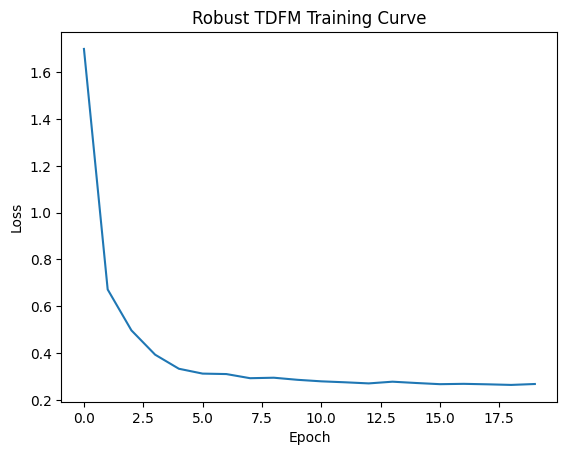

MF   RMSE=0.6222  MAE=0.4075
TDFM RMSE=0.5305  MAE=0.3417
ΔRMSE (MF-TDFM)=0.0917   ΔMAE (MF-TDFM)=0.0659   time=21.8s
Saved TDFM -> .\tdfm_model_seed3.pt

===== SEED 4 =====
[MF] Epoch 00 | Train MSE: 1.9031
[MF] Epoch 05 | Train MSE: 0.0742
[MF] Epoch 10 | Train MSE: 0.0393
[MF] Epoch 15 | Train MSE: 0.0314
[MF] Final Test RMSE: 0.6107

Starting Robust TDFM Training...
[TDFM] Epoch 00 | Loss=1.7081 | MSE=1.5087
[TDFM] Epoch 05 | Loss=0.3046 | MSE=0.1090
[TDFM] Epoch 10 | Loss=0.2845 | MSE=0.0896
[TDFM] Epoch 15 | Loss=0.2774 | MSE=0.0804

Sample Predictions vs Actuals:
Pred: [4.8087792 4.828246  4.8605156 4.881712  4.767796 ]
True: [5. 5. 4. 5. 5.]

[TDFM] Final Test RMSE: 0.5404
[TDFM] Saved model -> .\tdfm_model_seed4.pt


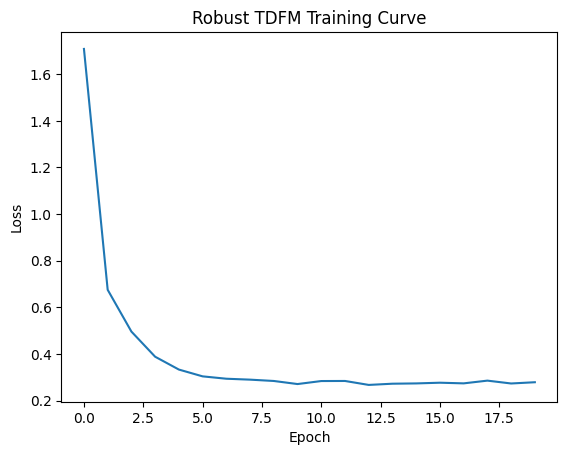

MF   RMSE=0.6107  MAE=0.4013
TDFM RMSE=0.5404  MAE=0.3407
ΔRMSE (MF-TDFM)=0.0703   ΔMAE (MF-TDFM)=0.0605   time=18.8s
Saved TDFM -> .\tdfm_model_seed4.pt


,seed,mf_rmse,mf_mae,tdfm_rmse,tdfm_mae,d_rmse,d_mae,tdfm_ckpt,seconds
0,2,0.622479,0.406673,0.527447,0.332986,0.095032,0.073687,.\tdfm_model_seed2.pt,20.651071
1,0,0.626041,0.407052,0.528863,0.335982,0.097179,0.071070,.\tdfm_model_seed0.pt,19.340504
2,3,0.622199,0.407545,0.530469,0.341659,0.091730,0.065887,.\tdfm_model_seed3.pt,21.755501
3,4,0.610732,0.401252,0.540397,0.340705,0.070335,0.060547,.\tdfm_model_seed4.pt,18.814270
4,1,0.639285,0.413964,0.549855,0.343049,0.089429,0.070916,.\tdfm_model_seed1.pt,20.402527



ΔRMSE (MF-TDFM): mean=0.0887, std=0.0107 over 5 seeds
ΔMAE  (MF-TDFM): mean=0.0684,  std=0.0052 over 5 seeds

Best TDFM seed by RMSE: seed=2  TDFM_RMSE=0.5274  ckpt=.\tdfm_model_seed2.pt


In [ ]:
import time

# ---- sanity checks (fail fast with clear messages) ----
required = ["meta", "set_seed", "train_mf_from_loaders", "train_tdfm_from_loaders",
            "predict_mf", "predict_tdfm", "rmse", "mae",
            "mf_train_loader", "mf_test_loader", "td_train_loader", "td_test_loader", "DEVICE"]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Missing required variables/functions: {missing}")

n_users = int(meta["n_users"])
n_items = int(meta["n_items"])
vocab_size = int(meta.get("vocab_size", globals().get("vocab_size", None)))
if vocab_size is None:
    raise NameError("Could not find vocab_size (expected meta['vocab_size'] or global vocab_size).")

SAVE_DIR = globals().get("SAVE_DIR", ".")
os.makedirs(SAVE_DIR, exist_ok=True)

# choose seeds (edit as you like)
SEEDS = globals().get("SEEDS", [0, 1, 2, 3, 4])

rows = []

for seed in SEEDS:
    print(f"\n===== SEED {seed} =====")
    set_seed(seed)
    t0 = time.time()

    # ---- MF ----
    mf_test_rmse_trainfn, mf_losses, mf_model = train_mf_from_loaders(
        mf_train_loader, mf_test_loader,
        n_users=n_users, n_items=n_items,
        device=DEVICE
    )
    mf_pred, y_test = predict_mf(mf_model, mf_test_loader, device=DEVICE)
    mf_rmse = rmse(mf_pred, y_test)
    mf_mae  = mae(mf_pred, y_test)

    # ---- TDFM ----
    tdfm_path = os.path.join(SAVE_DIR, f"tdfm_model_seed{seed}.pt")
    td_test_rmse_trainfn, td_losses, tdfm_model = train_tdfm_from_loaders(
        td_train_loader, td_test_loader,
        n_users=n_users, n_items=n_items, vocab_size=vocab_size,
        device=DEVICE,
        save_path=tdfm_path
    )
    td_pred, y_test2 = predict_tdfm(tdfm_model, td_test_loader, device=DEVICE)

    # ensure we are comparing on the exact same targets
    if len(y_test2) != len(y_test) or (not np.allclose(y_test2, y_test)):
        raise ValueError("y_test mismatch between MF and TDFM loaders. They must be the same split/order.")

    td_rmse = rmse(td_pred, y_test)
    td_mae  = mae(td_pred, y_test)

    d_rmse = mf_rmse - td_rmse
    d_mae  = mf_mae  - td_mae
    secs = time.time() - t0

    print(f"MF   RMSE={mf_rmse:.4f}  MAE={mf_mae:.4f}")
    print(f"TDFM RMSE={td_rmse:.4f}  MAE={td_mae:.4f}")
    print(f"ΔRMSE (MF-TDFM)={d_rmse:.4f}   ΔMAE (MF-TDFM)={d_mae:.4f}   time={secs:.1f}s")
    print(f"Saved TDFM -> {tdfm_path}")

    rows.append(dict(
        seed=int(seed),
        mf_rmse=float(mf_rmse), mf_mae=float(mf_mae),
        tdfm_rmse=float(td_rmse), tdfm_mae=float(td_mae),
        d_rmse=float(d_rmse), d_mae=float(d_mae),
        tdfm_ckpt=tdfm_path,
        seconds=float(secs)
    ))

df = pd.DataFrame(rows).sort_values("tdfm_rmse").reset_index(drop=True)
display(df)

def _summ(x):
    x = np.asarray(x, dtype=float)
    return float(x.mean()), float(x.std(ddof=1)) if len(x) > 1 else 0.0

m_rmse, s_rmse = _summ(df["d_rmse"])
m_mae,  s_mae  = _summ(df["d_mae"])
print(f"\nΔRMSE (MF-TDFM): mean={m_rmse:.4f}, std={s_rmse:.4f} over {len(df)} seeds")
print(f"ΔMAE  (MF-TDFM): mean={m_mae:.4f},  std={s_mae:.4f} over {len(df)} seeds")

best = df.iloc[int(df["tdfm_rmse"].argmin())]
print(f"\nBest TDFM seed by RMSE: seed={int(best.seed)}  TDFM_RMSE={best.tdfm_rmse:.4f}  ckpt={best.tdfm_ckpt}")

### 7. Topic inspection (uses saved vocab; no vectorizer rebuild)

This block inspects the learned topics by reading the decoder weights from a trained TDFM checkpoint and mapping them back to tokens using the saved vocabulary (tdfm_vocab.npy).

If we ran the multi-seed training/evaluation above, the code will automatically use the best seed checkpoint (lowest test RMSE) for topic inspection.

If no multi-seed summary exists, it falls back to the checkpoint we pass via model_path (or the default behavior inside analyze_model_topics).

In [ ]:
# Topic inspection: here we load the full hybrid TDFM checkpoint + saved vocab
# - Confirms the checkpoint contains the hybrid model components (user/item embeddings + encoder/decoder)
# - Shows top words per topic
# - Estimates topic prevalence by averaging theta on a sample of bag-of-words inputs

def _pick_default_ckpt():
    # Prefer the best checkpoint from the multi-seed sweep (if present)
    if "best" in globals():
        try:
            if isinstance(best, dict) and "tdfm_ckpt" in best:
                return str(best["tdfm_ckpt"])
            # pandas Series row
            if hasattr(best, "tdfm_ckpt"):
                return str(best.tdfm_ckpt)
            if hasattr(best, "__getitem__") and "tdfm_ckpt" in best:
                return str(best["tdfm_ckpt"])
        except Exception:
            pass

    # Fall back to the single-run checkpoint
    if os.path.exists("tdfm_model.pt"):
        return "tdfm_model.pt"

    # Otherwise try seed_runs/
    if os.path.isdir("seed_runs"):
        pts = [os.path.join("seed_runs", f) for f in os.listdir("seed_runs") if f.endswith(".pt")]
        if len(pts) > 0:
            pts.sort(key=lambda p: os.path.getmtime(p), reverse=True)
            return pts[0]

    raise FileNotFoundError("No TDFM checkpoint found. Expected tdfm_model.pt or seed_runs/*.pt")

def _load_state_dict(path, device="cpu"):
    obj = torch.load(path, map_location=device)
    # Support either raw state_dict or a bundle {"state_dict": ..., "config": ...}
    if isinstance(obj, dict) and "state_dict" in obj and isinstance(obj["state_dict"], dict):
        return obj["state_dict"], obj.get("config", {})
    if isinstance(obj, dict):
        return obj, {}
    raise TypeError(f"Unexpected checkpoint format: {type(obj)}")

def _infer_config_from_state_dict(sd):
    """Infer key dimensions from a saved checkpoint.

    This notebook's TDFM class uses `user_embedding` / `item_embedding` by default,
    but older variants may use `user_emb` / `item_emb`. We detect both.
    """

    def _pick(candidates, regex=None):
        for k in candidates:
            if k in sd:
                return k
        if regex is not None:
            for k in sd.keys():
                if re.search(regex, k):
                    return k
        return None

    # Possible embedding key names across variants
    user_k = _pick(
        ["user_embedding.weight", "user_emb.weight", "user_factors.weight", "user_latent.weight"],
        regex=r"user.*emb.*\.weight$|user.*factor.*\.weight$|user.*latent.*\.weight$",
    )
    item_k = _pick(
        ["item_embedding.weight", "item_emb.weight", "item_factors.weight", "item_latent.weight"],
        regex=r"item.*emb.*\.weight$|item.*factor.*\.weight$|item.*latent.*\.weight$",
    )

    # Decoder key (topic-word weights)
    dec_k = _pick(["decoder.weight"], regex=r"decoder.*\.weight$")

    missing = []
    if dec_k is None:
        missing.append("decoder.weight (or compatible decoder key)")
    if user_k is None:
        missing.append("user embedding weight key")
    if item_k is None:
        missing.append("item embedding weight key")
    if missing:
        # Show a few keys to help debug without flooding output
        preview = list(sd.keys())[:25]
        raise KeyError(f"Checkpoint is missing keys needed to reconstruct TDFM: {missing}. Example keys: {preview}")

    num_users = sd[user_k].shape[0]
    num_items = sd[item_k].shape[0]
    emb_dim   = sd[user_k].shape[1]
    vocab_size = sd[dec_k].shape[0]   # Linear(out=vocab_size, in=num_topics)
    num_topics = sd[dec_k].shape[1]

    return {
        "num_users": int(num_users),
        "num_items": int(num_items),
        "emb_dim": int(emb_dim),
        "vocab_size": int(vocab_size),
        "num_topics": int(num_topics),
        "user_key": user_k,
        "item_key": item_k,
        "decoder_key": dec_k,
    }


def _top_words_by_topic(W, vocab, top_k=10):
    """Return top_k vocab words for each topic column in W.

    Parameters
    ----------
    W : torch.Tensor or np.ndarray, shape (V, K)
        Decoder weight matrix where rows correspond to vocab terms and columns to topics.
    vocab : array-like of length V
        Vocabulary tokens aligned with rows of W.
    top_k : int
        Number of top words per topic.

    Returns
    -------
    list[list[str]]
        topic_words[k] is a list of top_k tokens for topic k.
    """
    try:
        if isinstance(W, torch.Tensor):
            Wn = W.detach().cpu().numpy()
        else:
            Wn = np.asarray(W)
    except Exception:
        Wn = np.asarray(W)

    # normalize vocab to list[str]
    if hasattr(vocab, "tolist"):
        v = vocab.tolist()
    else:
        v = list(vocab)
    v = [str(t) for t in v]

    V, K = Wn.shape
    topic_words = []
    for k in range(K):
        idx = np.argsort(-Wn[:, k])[:top_k]
        topic_words.append([v[int(i)] for i in idx])
    return topic_words

def analyze_model_topics(model_path=None, vocab_path="tdfm_vocab.npy", top_k=10, device="cpu",
                         bow_matrix=None, bow_sample_size=5000, seed=0):
    if model_path is None:
        model_path = _pick_default_ckpt()

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Missing checkpoint: {model_path}")
    if not os.path.exists(vocab_path):
        raise FileNotFoundError(f"Missing vocab file: {vocab_path} (run the training cell that saves vocab first)")

    vocab = np.load(vocab_path, allow_pickle=True)
    sd, cfg0 = _load_state_dict(model_path, device=device)
    cfg = _infer_config_from_state_dict(sd)

    print("=== Loaded checkpoint ===")
    print(f"ckpt: {model_path}")
    print(f"detected keys: user={cfg['user_key']}, item={cfg['item_key']}, decoder={cfg['decoder_key']}")
    print(f"ckpt: {model_path}")
    print(f"vocab: {vocab_path}  (|V|={len(vocab)})")
    print("inferred config:", cfg)

    # Sanity: confirm hybrid components exist
    key_snippets = [k for k in sd.keys() if any(s in k for s in ["user_emb", "item_emb", "encoder", "decoder", "rating"])]
    print(f"checkpoint contains {len(sd)} tensors; showing a few hybrid-related keys:")
    for k in sorted(key_snippets)[:20]:
        print("  -", k)

    # Reconstruct full model and load weights
    model = TDFM(cfg["num_users"], cfg["num_items"], cfg["vocab_size"],
                 num_topics=cfg["num_topics"], emb_dim=cfg["emb_dim"])
    # Normalize common key-name variants (older notebooks used user_emb/item_emb)
    if "user_emb.weight" in sd and "user_embedding.weight" not in sd:
        sd["user_embedding.weight"] = sd.pop("user_emb.weight")
    if "item_emb.weight" in sd and "item_embedding.weight" not in sd:
        sd["item_embedding.weight"] = sd.pop("item_emb.weight")

    incompatible = model.load_state_dict(sd, strict=False)
    if getattr(incompatible, "missing_keys", None):
        if len(incompatible.missing_keys) > 0:
            print(f"[topic] Warning: missing keys when loading checkpoint: {incompatible.missing_keys[:10]}{' ...' if len(incompatible.missing_keys)>10 else ''}")
    if getattr(incompatible, "unexpected_keys", None):
        if len(incompatible.unexpected_keys) > 0:
            print(f"[topic] Warning: unexpected keys in checkpoint: {incompatible.unexpected_keys[:10]}{' ...' if len(incompatible.unexpected_keys)>10 else ''}")
    model.eval()

    # Topics from decoder weights
    W = model.decoder.weight.detach()  # [V, K]
    topic_words = _top_words_by_topic(W, vocab, top_k=top_k)

    print("\n=== Top words per topic (by decoder weights) ===")
    for k, words in enumerate(topic_words):
        print(f"Topic {k:02d}: " + ", ".join(words))

    # Estimate prevalence by averaging theta on a bow matrix (if provided)
    if bow_matrix is not None:
        rng = np.random.default_rng(seed)
        X = bow_matrix
        if hasattr(X, "toarray"):
            # sparse -> dense sample only
            n = X.shape[0]
            idx = rng.choice(n, size=min(bow_sample_size, n), replace=False)
            Xs = X[idx].toarray()
        else:
            X = np.asarray(X)
            n = X.shape[0]
            idx = rng.choice(n, size=min(bow_sample_size, n), replace=False)
            Xs = X[idx]

        Xs = torch.tensor(Xs, dtype=torch.float32)
        with torch.no_grad():
            h = F.relu(model.encoder_fc1(Xs))
            h = model.encoder_drop(h)
            theta_logits = model.encoder_fc2(h)
            theta = F.softmax(theta_logits, dim=1)  # [N, K]
            prev = theta.mean(dim=0).cpu().numpy()

        order = np.argsort(-prev)
        print("\n=== Topic prevalence (avg theta on sampled BOW rows) ===")
        for rank, k in enumerate(order[:min(10, len(order))], start=1):
            print(f"{rank:02d}. Topic {int(k):02d}: prevalence={prev[k]:.4f} | words: " + ", ".join(topic_words[int(k)]))
    else:
        print("\n(prevalence not computed) Tip: pass bow_matrix=reviews_all (or the BOW matrix you built) to estimate topic prevalence.")

# Use the in-memory bag-of-words if available (no rebuild)
bow_for_prev = None
if "reviews_all" in globals():
    bow_for_prev = reviews_all

# --- Pick checkpoint for topic inspection (best-seed if multi-seed summary exists) ---
best_ckpt_path = None
if 'best' in globals():
    try:
        best_ckpt_path = str(best.tdfm_ckpt)
    except Exception:
        try:
            best_ckpt_path = str(best['tdfm_ckpt'])
        except Exception:
            best_ckpt_path = None
if best_ckpt_path is None and 'df' in globals():
    try:
        if 'tdfm_rmse' in df.columns and 'tdfm_ckpt' in df.columns:
            _idx = df['tdfm_rmse'].astype(float).idxmin()
            best_ckpt_path = str(df.loc[_idx, 'tdfm_ckpt'])
    except Exception:
        pass
if best_ckpt_path is not None and str(best_ckpt_path).lower() not in ['none', 'nan', '']:
    print(f"[topic] Using best checkpoint: {best_ckpt_path}")
else:
    best_ckpt_path = None
    print("[topic] No best-seed checkpoint found; using default model_path=None.")

analyze_model_topics(model_path=best_ckpt_path, vocab_path="tdfm_vocab.npy", top_k=10, device="cpu", bow_matrix=bow_for_prev)

[topic] Using best checkpoint: .\tdfm_model_seed2.pt
=== Loaded checkpoint ===
ckpt: .\tdfm_model_seed2.pt
detected keys: user=user_embedding.weight, item=item_embedding.weight, decoder=decoder.weight
ckpt: .\tdfm_model_seed2.pt
vocab: tdfm_vocab.npy  (|V|=1000)
inferred config: {'num_users': 2021, 'num_items': 100, 'emb_dim': 8, 'vocab_size': 1000, 'num_topics': 10, 'user_key': 'user_embedding.weight', 'item_key': 'item_embedding.weight', 'decoder_key': 'decoder.weight'}
checkpoint contains 14 tensors; showing a few hybrid-related keys:
  - decoder.weight
  - decoder_bn.num_batches_tracked
  - decoder_bn.running_mean
  - decoder_bn.running_var
  - encoder_fc1.bias
  - encoder_fc1.weight
  - encoder_fc2.bias
  - encoder_fc2.weight
  - item_embedding.weight
  - user_embedding.weight

=== Top words per topic (by decoder weights) ===
Topic 00: completely, thighs, celery, care, did, breasts, breast, don, really, soy
Topic 01: try, cups, dish, cheesecake, fudge, follow, leave, served, recip

### 8. Robustness upgrades (trained ablation + topic-collapse diagnostics + ranking sweep)

We add three high-ROI upgrades in this section:

- Trained no-topic ablation (fair): retrain a model without the topic/text term (not just dropping it at inference).
- Topic-collapse diagnostics (entropy/effective-topics + concentration checks on θ).
- Ranking robustness sweep over (N_neg, K) plus slice evaluations and user-level bootstrap CIs.

Note: In the ranking sweep we report both:
- NoTopic_trained (fair retrained ablation), and
- TDFM_obs_no_topic (diagnostic drop-at-inference: omit the topic term at scoring time).

In [ ]:
# ===== 8.1 Trained no-topic ablation (retrain) =====

# DEVICE = globals().get("DEVICE", "cuda" if torch.cuda.is_available() else "cpu")
SEED = int(globals().get("SEED", 0))

def _set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

def rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

def mae_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.mean(np.abs(yhat - y)))

# Ensure exposure_matrix exists (same logic as earlier cell)
if "exposure_matrix" not in globals():
    conf_obj = torch.load(CONFOUNDER_PATH, map_location="cpu")
    if isinstance(conf_obj, dict) and ("Z_hat" in conf_obj):
        exposure_matrix = conf_obj["Z_hat"]
    else:
        exposure_matrix = conf_obj
    if not torch.is_tensor(exposure_matrix):
        exposure_matrix = torch.tensor(exposure_matrix)
    exposure_matrix = exposure_matrix.float()
    print("exposure_matrix:", tuple(exposure_matrix.shape), exposure_matrix.min().item(), exposure_matrix.max().item())

def get_exposure_vec(user_id: int, item_ids: np.ndarray) -> np.ndarray:
    u = int(user_id)
    it = torch.tensor(item_ids, dtype=torch.long)
    return exposure_matrix[u, it].numpy().reshape(-1)

# A trained ablation: remove topic encoder/decoder + topic_bias, keep MF + exposure
class TDFMNoTopic(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=EMBEDDING_DIM):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, emb_dim)
        self.item_embedding = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.mf_drop = nn.Dropout(0.2)
        self.exposure_bias = nn.Linear(1, 1, bias=False)

        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        self.user_bias.weight.data.fill_(0.0)
        self.item_bias.weight.data.fill_(0.0)

    def forward(self, user_idx, item_idx, exposure_val):
        u_emb = self.user_embedding(user_idx)
        i_emb = self.item_embedding(item_idx)
        interaction = (u_emb * i_emb).sum(dim=1, keepdim=True)
        interaction = self.mf_drop(interaction)
        u_b = self.user_bias(user_idx)
        i_b = self.item_bias(item_idx)
        bias_exposure = self.exposure_bias(exposure_val)
        raw_score = interaction + u_b + i_b + bias_exposure
        pred = torch.sigmoid(raw_score) * 4.0 + 1.0
        return pred.squeeze(1)

def train_notopic_from_td_loaders(train_loader, test_loader, n_users, n_items,
                                 emb_dim=EMBEDDING_DIM, epochs=None, lr=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY, device=DEVICE, save_path="tdfm_no_topic.pt"):
    _set_seed(SEED)
    if epochs is None:
        epochs = int(globals().get("EPOCHS", 30))
    model = TDFMNoTopic(n_users, n_items, emb_dim=emb_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()
    t0 = time.time()
    for ep in range(epochs):
        total_mse, nb = 0.0, 0
        for users, items, reviews, exposure, ratings in train_loader:
            users = users.to(device)
            items = items.to(device)
            exposure = exposure.to(device)
            ratings = ratings.to(device)

            opt.zero_grad()
            pred = model(users, items, exposure)
            loss = F.mse_loss(pred, ratings)
            loss.backward()
            opt.step()

            total_mse += loss.item()
            nb += 1

        if ep % 5 == 0:
            print(f"[NoTopic] Epoch {ep:02d} | MSE={total_mse/max(nb,1):.4f}")

    model.eval()
    torch.save(model.state_dict(), save_path)
    print(f"Saved trained no-topic model -> {save_path} (time: {time.time()-t0:.1f}s)")
    return model

# Train (only if not already trained in this session)
if "tdfm_no_topic_model" not in globals():
    tdfm_no_topic_model = train_notopic_from_td_loaders(
        td_train_loader, td_test_loader,
        n_users=meta["n_users"], n_items=meta["n_items"],
        epochs=int(globals().get("EPOCHS_NOTOPIC", min(int(globals().get("EPOCHS", 30)), 30))),
        save_path="tdfm_no_topic.pt"
    )
else:
    print("tdfm_no_topic_model already exists; skipping retrain.")

tdfm_no_topic_model.eval()
tdfm_no_topic_model.to(DEVICE)

[NoTopic] Epoch 00 | MSE=2.4887
[NoTopic] Epoch 05 | MSE=0.1959
[NoTopic] Epoch 10 | MSE=0.1309
[NoTopic] Epoch 15 | MSE=0.1191
Saved trained no-topic model -> tdfm_no_topic.pt (time: 6.5s)


TDFMNoTopic(
  (user_embedding): Embedding(2021, 8)
  (item_embedding): Embedding(100, 8)
  (user_bias): Embedding(2021, 1)
  (item_bias): Embedding(100, 1)
  (mf_drop): Dropout(p=0.2, inplace=False)
  (exposure_bias): Linear(in_features=1, out_features=1, bias=False)
)

In [ ]:
# ===== 8.2 Evaluate trained no-topic ablation on the SAME aligned test set (u_test, i_test, y_test) =====
@torch.no_grad()
def predict_notopic_on_aligned_test(model, u_test, i_test, batch_size=2048):
    model.eval()
    preds = []
    n = len(u_test)
    for s in range(0, n, batch_size):
        uu = torch.tensor(u_test[s:s+batch_size], device=DEVICE, dtype=torch.long)
        ii = torch.tensor(i_test[s:s+batch_size], device=DEVICE, dtype=torch.long)
        exp = torch.tensor(get_exposure_vec_batch(u_test[s:s+batch_size], i_test[s:s+batch_size]),
                           device=DEVICE, dtype=torch.float32).view(-1,1)
        p = model(uu, ii, exp)
        preds.append(p.detach().cpu().numpy().reshape(-1))
    return np.concatenate(preds)

def get_exposure_vec_batch(u_batch, i_batch):
    # vectorized exposure lookup for aligned pairs
    u_batch = np.asarray(u_batch, dtype=int).reshape(-1)
    i_batch = np.asarray(i_batch, dtype=int).reshape(-1)
    exp = exposure_matrix[u_batch, i_batch].numpy().reshape(-1)
    return exp

# ensure aligned arrays exist from earlier section
assert "u_test" in globals() and "i_test" in globals() and "y_test" in globals(), "Need u_test/i_test/y_test from earlier evaluation section."

no_topic_pred_trained = predict_notopic_on_aligned_test(tdfm_no_topic_model, u_test, i_test)
print("Trained NoTopic RMSE/MAE:", rmse_np(no_topic_pred_trained, y_test), mae_np(no_topic_pred_trained, y_test))

# add to test_df if present
if "test_df" in globals():
    test_df["notopic_trained_pred"] = no_topic_pred_trained
    display(test_df.head())

Trained NoTopic RMSE/MAE: 0.6465311646461487 0.46096909046173096


,user_id,item_id,rating,mf_pred,td_pred,item_pop_bin,user_hist_bin,notopic_trained_pred
0,1405,7,5.0,4.857408,4.793510,pop_bin_1,hist_bin_1,4.764367
1,100,51,5.0,4.841021,4.549818,pop_bin_0,hist_bin_3,4.678288
2,700,46,4.0,4.790134,4.821331,pop_bin_3,hist_bin_1,4.691686
3,1552,22,5.0,4.794485,4.863258,pop_bin_1,hist_bin_2,4.901608
4,143,57,5.0,4.833173,4.732249,pop_bin_1,hist_bin_3,4.808285


In [ ]:
# ===== 8.3 Bootstrap deltas: MF vs full TDFM vs trained no-topic =====
# Uses paired bootstrap over test points AND block bootstrap over users

B = int(globals().get("BOOTSTRAP_B", 2000))
rng = np.random.default_rng(int(globals().get("SEED", 0)))

mf_p = np.asarray(mf_pred).reshape(-1)
td_p = np.asarray(td_pred).reshape(-1)
nt_p = np.asarray(no_topic_pred_trained).reshape(-1)
y   = np.asarray(y_test).reshape(-1)

def paired_bootstrap_ci(delta_fn, B=B):
    n = len(y)
    stats = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        stats.append(delta_fn(idx))
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return float(np.mean(stats)), float(lo), float(hi)

# paired: MF - model (positive means model better)
def delta_rmse(m1, m2, idx):
    return rmse_np(m1[idx], y[idx]) - rmse_np(m2[idx], y[idx])

def delta_mae(m1, m2, idx):
    return mae_np(m1[idx], y[idx]) - mae_np(m2[idx], y[idx])

pairs = [
    ("MF", "TDFM(full)", mf_p, td_p),
    ("MF", "NoTopic(trained)", mf_p, nt_p),
    ("NoTopic(trained)", "TDFM(full)", nt_p, td_p),
]

rows=[]
for a_name, b_name, a_pred, b_pred in pairs:
    m, lo, hi = paired_bootstrap_ci(lambda idx, ap=a_pred, bp=b_pred: delta_rmse(ap, bp, idx))
    rows.append({"comparison": f"{a_name} - {b_name}", "metric": "ΔRMSE", "mean": m, "ci_low": lo, "ci_high": hi})
    m, lo, hi = paired_bootstrap_ci(lambda idx, ap=a_pred, bp=b_pred: delta_mae(ap, bp, idx))
    rows.append({"comparison": f"{a_name} - {b_name}", "metric": "ΔMAE", "mean": m, "ci_low": lo, "ci_high": hi})

display(pd.DataFrame(rows))

# User-block bootstrap for MF - NoTopic(trained)
u_arr = np.asarray(u_test).reshape(-1)
unique_users = np.unique(u_arr)
user_to_idx = {u: np.where(u_arr == u)[0] for u in unique_users}

def user_block_bootstrap_delta(pred_a, pred_b, metric="rmse", B=B):
    stats=[]
    U = len(unique_users)
    for _ in range(B):
        sampled_users = rng.choice(unique_users, size=U, replace=True)
        idx = np.concatenate([user_to_idx[u] for u in sampled_users])
        if metric == "rmse":
            stats.append(rmse_np(pred_a[idx], y[idx]) - rmse_np(pred_b[idx], y[idx]))
        else:
            stats.append(mae_np(pred_a[idx], y[idx]) - mae_np(pred_b[idx], y[idx]))
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return float(np.mean(stats)), float(lo), float(hi)

m, lo, hi = user_block_bootstrap_delta(mf_p, nt_p, metric="rmse")
print(f"[User-block] ΔRMSE (MF - NoTopic(trained)) mean={m:.4f} 95%CI=[{lo:.4f},{hi:.4f}]")
m, lo, hi = user_block_bootstrap_delta(mf_p, nt_p, metric="mae")
print(f"[User-block] ΔMAE  (MF - NoTopic(trained)) mean={m:.4f} 95%CI=[{lo:.4f},{hi:.4f}]")

,comparison,metric,mean,ci_low,ci_high
0,MF - TDFM(full),ΔRMSE,0.069936,0.044015,0.096654
1,MF - TDFM(full),ΔMAE,0.060254,0.045059,0.075685
2,MF - NoTopic(trained),ΔRMSE,-0.036176,-0.054312,-0.017546
3,MF - NoTopic(trained),ΔMAE,-0.059694,-0.072045,-0.047426
4,NoTopic(trained) - TDFM(full),ΔRMSE,0.106187,0.080132,0.134236
5,NoTopic(trained) - TDFM(full),ΔMAE,0.120359,0.103718,0.137274


[User-block] ΔRMSE (MF - NoTopic(trained)) mean=-0.0361 95%CI=[-0.0556,-0.0172]
[User-block] ΔMAE  (MF - NoTopic(trained)) mean=-0.0594 95%CI=[-0.0723,-0.0462]


In [ ]:
# ===== 8.4 Topic-collapse diagnostics (entropy / effective topics / concentration) =====
# Uses TRAIN thetas inferred from the TDFM encoder, without touching test text.

assert "tdfm_model" in globals(), "Need trained tdfm_model."
tdfm_model.eval()
tdfm_model.to(DEVICE)

@torch.no_grad()
def infer_theta(bow_batch: torch.Tensor) -> np.ndarray:
    bow_batch = bow_batch.to(DEVICE).float()
    h = F.relu(tdfm_model.encoder_fc1(bow_batch))
    h = tdfm_model.encoder_drop(h)  # in eval() this is disabled
    mu = tdfm_model.encoder_fc2(h)
    theta = F.softmax(mu, dim=1)
    return theta.detach().cpu().numpy()

thetas=[]
max_batches = int(globals().get("THETA_DIAG_MAX_BATCHES", 200))  # keep it fast
for b, batch in enumerate(td_train_loader):
    if b >= max_batches: break
    u, it, bow, exposure, r = batch
    th = infer_theta(bow)
    thetas.append(th)

theta_all = np.concatenate(thetas, axis=0)
eps = 1e-12
entropy = -(theta_all * np.log(theta_all + eps)).sum(axis=1)                 # H(theta)
eff_topics = np.exp(entropy)                                                # effective number of topics
max_prob = theta_all.max(axis=1)

diag = pd.DataFrame({
    "entropy_mean": [float(entropy.mean())],
    "entropy_p10":  [float(np.percentile(entropy, 10))],
    "entropy_p50":  [float(np.percentile(entropy, 50))],
    "entropy_p90":  [float(np.percentile(entropy, 90))],
    "eff_topics_mean": [float(eff_topics.mean())],
    "eff_topics_p10":  [float(np.percentile(eff_topics, 10))],
    "eff_topics_p50":  [float(np.percentile(eff_topics, 50))],
    "eff_topics_p90":  [float(np.percentile(eff_topics, 90))],
    "frac_max_gt_0.9": [float((max_prob > 0.9).mean())],
    "frac_max_gt_0.8": [float((max_prob > 0.8).mean())],
})
display(diag)

# Topic prevalence on sampled train points
topic_prev = theta_all.mean(axis=0)
prev_df = pd.DataFrame({"topic": np.arange(len(topic_prev)), "prevalence": topic_prev}).sort_values("prevalence", ascending=False)
display(prev_df.head(10))

,entropy_mean,entropy_p10,entropy_p50,entropy_p90,eff_topics_mean,eff_topics_p10,eff_topics_p50,eff_topics_p90,frac_max_gt_0.9,frac_max_gt_0.8
0,0.393189,0.00024,0.070567,1.436242,1.942005,1.00024,1.073116,4.204866,0.722679,0.794371


,topic,prevalence
9,9,0.854622
7,7,0.069749
8,8,0.011293
2,2,0.010201
0,0,0.010097
1,1,0.009539
3,3,0.009231
5,5,0.008711
6,6,0.008354
4,4,0.008208


In [ ]:
# ===== 8.5 Ranking robustness sweep: (N_NEG × K) + user-level bootstrap CI =====
# We precompute per-user per-item scores once (items are only ~100, so this is cheap).

assert "users_eval" in globals() and "user_to_pos" in globals(), "Need users_eval and user_to_pos from ranking section."
users = np.array(users_eval, dtype=int)
nU = len(users)
nI = int(meta["n_items"])
item_universe = np.arange(nI, dtype=int)

tdfm_model.eval(); mf_model.eval()
tdfm_model.to(DEVICE); mf_model.to(DEVICE)

# Ensure item_topic_term exists (train-only item theta profile) for observed scoring
assert "item_topic_term" in globals(), "Need item_topic_term from earlier train-only topic profile cell."

@torch.no_grad()
def precompute_scores():
    # returns dict[name] -> (nU, nI) numpy scores
    scores = {}

    # Precompute item embeddings/biases for speed
    it = torch.tensor(item_universe, device=DEVICE, dtype=torch.long)
    mf_item_emb = mf_model.item_emb(it) if hasattr(mf_model, "item_emb") else mf_model.item_embedding(it)
    mf_item_b   = mf_model.item_b(it).squeeze(1) if hasattr(mf_model, "item_b") else mf_model.item_bias(it).squeeze(1)

    td_item_emb = tdfm_model.item_embedding(it)
    td_item_b   = tdfm_model.item_bias(it).squeeze(1)
    topic_term  = torch.tensor(item_topic_term[item_universe], device=DEVICE, dtype=torch.float32)

    # exposure bias for each user/item
    # we apply tdfm_model.exposure_bias to exp values
    exp_all = exposure_matrix[users][:, item_universe]  # (nU,nI) torch on CPU
    exp_all_t = exp_all.to(DEVICE).float().reshape(-1, 1)
    exp_term_all = tdfm_model.exposure_bias(exp_all_t).reshape(nU, nI)

    # user loop (nU ~ 875, nI ~ 100)
    mf_scores = np.zeros((nU, nI), dtype=np.float32)
    td_pref   = np.zeros((nU, nI), dtype=np.float32)
    td_obs    = np.zeros((nU, nI), dtype=np.float32)
    td_obs_nt = np.zeros((nU, nI), dtype=np.float32)
    nt_trained= np.zeros((nU, nI), dtype=np.float32)

    for idx_u, u in enumerate(users):
        uu = torch.full((nI,), int(u), device=DEVICE, dtype=torch.long)

        # MF
        mf_u_emb = mf_model.user_emb(uu) if hasattr(mf_model, "user_emb") else mf_model.user_embedding(uu)
        mf_u_b   = mf_model.user_b(uu).squeeze(1) if hasattr(mf_model, "user_b") else mf_model.user_bias(uu).squeeze(1)
        raw_mf = (mf_u_emb * mf_item_emb).sum(dim=1) + mf_u_b + mf_item_b
        mf_pred_all = torch.sigmoid(raw_mf) * 4.0 + 1.0
        mf_scores[idx_u] = mf_pred_all.detach().cpu().numpy()

        # TDFM preference (deconfounded)
        td_u_emb = tdfm_model.user_embedding(uu)
        td_u_b   = tdfm_model.user_bias(uu).squeeze(1)
        raw_pref = (td_u_emb * td_item_emb).sum(dim=1) + td_u_b + td_item_b
        td_pref_all = torch.sigmoid(raw_pref) * 4.0 + 1.0
        td_pref[idx_u] = td_pref_all.detach().cpu().numpy()

        # TDFM observed (with topic + exposure)
        raw_obs = raw_pref + topic_term + exp_term_all[idx_u]
        td_obs_all = torch.sigmoid(raw_obs) * 4.0 + 1.0
        td_obs[idx_u] = td_obs_all.detach().cpu().numpy()

        # TDFM observed no-topic
        raw_obs_nt = raw_pref + exp_term_all[idx_u]
        td_obs_nt_all = torch.sigmoid(raw_obs_nt) * 4.0 + 1.0
        td_obs_nt[idx_u] = td_obs_nt_all.detach().cpu().numpy()

        # Trained no-topic model observed (its own parameters)
        # (MF backbone + exposure, trained)
        uu2 = torch.full((nI,), int(u), device=DEVICE, dtype=torch.long)
        exp_u = exp_all[idx_u].to(DEVICE).float().view(-1,1)
        p = tdfm_no_topic_model(uu2, it, exp_u)
        nt_trained[idx_u] = p.detach().cpu().numpy()

    scores["MF"] = mf_scores
    scores["TDFM_pref"] = td_pref
    scores["TDFM_obs"] = td_obs
    scores["TDFM_obs_no_topic"] = td_obs_nt
    scores["NoTopic_trained_obs"] = nt_trained
    return scores

scores = precompute_scores()
print({k: v.shape for k,v in scores.items()})

def recall_at_k_from_rank(rank_items, pos_set, k):
    if len(pos_set) == 0: return np.nan
    return len(set(rank_items[:k]) & pos_set) / len(pos_set)

def ndcg_at_k_from_rank(rank_items, pos_set, k):
    if len(pos_set) == 0: return np.nan
    dcg=0.0
    for r,it in enumerate(rank_items[:k], start=1):
        if it in pos_set:
            dcg += 1.0 / math.log2(r+1)
    ideal = min(len(pos_set), k)
    idcg = sum((1.0/math.log2(r+1) for r in range(1, ideal+1)))
    return dcg/idcg if idcg>0 else np.nan

rng = np.random.default_rng(int(globals().get("SEED", 0)))

def eval_ranking_setting(N_NEG, K):
    # returns per-user recall/ndcg arrays for each model
    rec = {name: [] for name in scores.keys()}
    ndc = {name: [] for name in scores.keys()}
    for idx_u, u in enumerate(users):
        pos_items = np.array(user_to_pos[int(u)], dtype=int)
        pos_set = set(pos_items.tolist())

        # negatives: from items not in train or test positives
        banned = set(train_user_items.get(int(u), set())) | pos_set
        pool = np.array([it for it in item_universe if it not in banned], dtype=int)
        if len(pool) == 0:
            continue
        neg = rng.choice(pool, size=min(N_NEG, len(pool)), replace=(len(pool) < N_NEG))
        cand = np.unique(np.concatenate([pos_items, neg])).astype(int)

        for name, S in scores.items():
            sc = S[idx_u, cand]
            ranked = cand[np.argsort(-sc)]
            rec[name].append(recall_at_k_from_rank(ranked, pos_set, K))
            ndc[name].append(ndcg_at_k_from_rank(ranked, pos_set, K))
    # convert to arrays
    rec = {k: np.asarray(v, dtype=float) for k,v in rec.items()}
    ndc = {k: np.asarray(v, dtype=float) for k,v in ndc.items()}
    return rec, ndc

def bootstrap_ci(arr_delta, B=2000):
    arr_delta = np.asarray(arr_delta, dtype=float)
    n = len(arr_delta)
    if n == 0:
        return (np.nan, np.nan, np.nan)
    stats=[]
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        stats.append(np.nanmean(arr_delta[idx]))
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return float(np.nanmean(arr_delta)), float(lo), float(hi)

N_NEG_LIST = list(map(int, globals().get("RANK_NNEG_LIST", [20, 50, 100])))
K_LIST     = list(map(int, globals().get("RANK_K_LIST", [5, 10, 20])))
B_RANK     = int(globals().get("RANK_BOOTSTRAP_B", 2000))

summary_rows=[]
ci_rows=[]
for N_NEG in N_NEG_LIST:
    for K in K_LIST:
        rec, ndc = eval_ranking_setting(N_NEG=N_NEG, K=K)
        # means
        for name in scores.keys():
            summary_rows.append({"N_NEG": N_NEG, "K": K, "model": name,
                                 "Recall@K": float(np.nanmean(rec[name])),
                                 "NDCG@K":   float(np.nanmean(ndc[name]))})
        # CIs for deltas (model - MF)
        for name in ["TDFM_obs", "TDFM_obs_no_topic", "NoTopic_trained_obs", "TDFM_pref"]:
            d_rec = rec[name] - rec["MF"]
            d_ndc = ndc[name] - ndc["MF"]
            m, lo, hi = bootstrap_ci(d_rec, B=B_RANK)
            ci_rows.append({"N_NEG": N_NEG, "K": K, "metric": f"ΔRecall@{K} ({name}-MF)", "mean": m, "ci_low": lo, "ci_high": hi})
            m, lo, hi = bootstrap_ci(d_ndc, B=B_RANK)
            ci_rows.append({"N_NEG": N_NEG, "K": K, "metric": f"ΔNDCG@{K} ({name}-MF)", "mean": m, "ci_low": lo, "ci_high": hi})

summary_df = pd.DataFrame(summary_rows)
ci_df = pd.DataFrame(ci_rows)

display(summary_df.sort_values(["N_NEG","K","model"]))
display(ci_df.sort_values(["N_NEG","K","metric"]))

{'MF': (875, 100), 'TDFM_pref': (875, 100), 'TDFM_obs': (875, 100), 'TDFM_obs_no_topic': (875, 100), 'NoTopic_trained_obs': (875, 100)}


,N_NEG,K,model,Recall@K,NDCG@K
0,20,5,MF,0.435064,0.340842
4,20,5,NoTopic_trained_obs,0.689056,0.582409
2,20,5,TDFM_obs,0.472833,0.334130
3,20,5,TDFM_obs_no_topic,0.502014,0.369025
1,20,5,TDFM_pref,0.345080,0.215824
5,20,10,MF,0.622476,0.400902
9,20,10,NoTopic_trained_obs,0.824193,0.628433
7,20,10,TDFM_obs,0.667891,0.395714
8,20,10,TDFM_obs_no_topic,0.684245,0.424924
6,20,10,TDFM_pref,0.584672,0.297939


,N_NEG,K,metric,mean,ci_low,ci_high
5,20,5,ΔNDCG@5 (NoTopic_trained_obs-MF),0.241567,0.218619,0.264929
1,20,5,ΔNDCG@5 (TDFM_obs-MF),-0.006712,-0.031311,0.017045
3,20,5,ΔNDCG@5 (TDFM_obs_no_topic-MF),0.028183,0.004756,0.053278
7,20,5,ΔNDCG@5 (TDFM_pref-MF),-0.125017,-0.149322,-0.099697
4,20,5,ΔRecall@5 (NoTopic_trained_obs-MF),0.253992,0.222519,0.284286
...,...,...,...,...,...,...
71,100,20,ΔNDCG@20 (TDFM_pref-MF),-0.118443,-0.139266,-0.097441
68,100,20,ΔRecall@20 (NoTopic_trained_obs-MF),0.268490,0.238702,0.298841
64,100,20,ΔRecall@20 (TDFM_obs-MF),0.062291,0.031070,0.094719
66,100,20,ΔRecall@20 (TDFM_obs_no_topic-MF),0.084607,0.053167,0.116319


In [ ]:
# ===== Summary =====

def _rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

def _mae_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.mean(np.abs(yhat - y)))

def _fmt(x):
    return "NA" if x is None else f"{x:.4f}"

# Pull aligned vectors (prefer test_df if available)
y = np.asarray(y_test).reshape(-1) if "y_test" in globals() else None

mf_vec = None
td_vec = None
nt_tr_vec = None

if "test_df" in globals():
    if "rating" in test_df.columns and y is None:
        y = test_df["rating"].to_numpy().reshape(-1)
    if "mf_pred" in test_df.columns:
        mf_vec = test_df["mf_pred"].to_numpy().reshape(-1)
    if "td_pred" in test_df.columns:
        td_vec = test_df["td_pred"].to_numpy().reshape(-1)
    if "notopic_trained_pred" in test_df.columns:
        nt_tr_vec = test_df["notopic_trained_pred"].to_numpy().reshape(-1)

# fallback to globals
if mf_vec is None and "mf_pred" in globals():
    mf_vec = np.asarray(mf_pred).reshape(-1)
if td_vec is None and "td_pred" in globals():
    td_vec = np.asarray(td_pred).reshape(-1)

# trained no-topic (preferred ablation)
if nt_tr_vec is None:
    if "no_topic_pred_trained" in globals():
        nt_tr_vec = np.asarray(no_topic_pred_trained).reshape(-1)

# diagnostic (inference-time removal; not fair)
nt_diag_vec = np.asarray(no_topic_pred).reshape(-1) if "no_topic_pred" in globals() else None
if nt_diag_vec is None and "nt_pred" in globals():  # alternate naming
    nt_diag_vec = np.asarray(nt_pred).reshape(-1)

def _safe_metrics(pred):
    if y is None or pred is None:
        return None, None
    if len(pred) != len(y):
        return None, None
    return _rmse_np(pred, y), _mae_np(pred, y)

rmse_mf_val, mae_mf_val = _safe_metrics(mf_vec)
rmse_td_val, mae_td_val = _safe_metrics(td_vec)
rmse_nt_tr, mae_nt_tr   = _safe_metrics(nt_tr_vec)
rmse_nt_diag, mae_nt_diag = _safe_metrics(nt_diag_vec)

# deltas (positive means second model is better)
gain_rmse = (rmse_mf_val - rmse_td_val) if (rmse_mf_val is not None and rmse_td_val is not None) else None
gain_mae  = (mae_mf_val  - mae_td_val)  if (mae_mf_val  is not None and mae_td_val  is not None) else None

gain_rmse_tr = (rmse_mf_val - rmse_nt_tr) if (rmse_mf_val is not None and rmse_nt_tr is not None) else None
gain_mae_tr  = (mae_mf_val  - mae_nt_tr)  if (mae_mf_val  is not None and mae_nt_tr  is not None) else None

topic_contrib_rmse_tr = (rmse_nt_tr - rmse_td_val) if (rmse_nt_tr is not None and rmse_td_val is not None) else None
topic_contrib_mae_tr  = (mae_nt_tr  - mae_td_val)  if (mae_nt_tr  is not None and mae_td_val  is not None) else None

summary = f"""Results summary (aligned test set)
• MF RMSE/MAE = {_fmt(rmse_mf_val)}/{_fmt(mae_mf_val)}
• TDFM(full) RMSE/MAE = {_fmt(rmse_td_val)}/{_fmt(mae_td_val)}
⇒ Improvement (MF − Full): ΔRMSE = {_fmt(gain_rmse)}, ΔMAE = {_fmt(gain_mae)}

Ablation (trained no-topic; fair)
• NoTopic(trained) RMSE/MAE = {_fmt(rmse_nt_tr)}/{_fmt(mae_nt_tr)}
⇒ Improvement (MF − NoTopic trained): ΔRMSE = {_fmt(gain_rmse_tr)}, ΔMAE = {_fmt(gain_mae_tr)}
⇒ Topic contribution (NoTopic trained − Full): ΔRMSE = {_fmt(topic_contrib_rmse_tr)}, ΔMAE = {_fmt(topic_contrib_mae_tr)}
(Positive means the topic/text component helps rating prediction.)

Notes
• Ranking metrics are reported separately (Recall@K / NDCG@K with negative sampling).
• If shown, “NoTopic (inference-time removal)” is *diagnostic only* and not a fair ablation because it was not retrained.
"""

print(summary.strip())

if rmse_nt_diag is not None and mae_nt_diag is not None:
    print("\n[Diagnostic only] NoTopic (inference-time removal) RMSE/MAE "
          f"= {_fmt(rmse_nt_diag)}/{_fmt(mae_nt_diag)}  (not a fair ablation)")

Results summary (aligned test set)
• MF RMSE/MAE = 0.6234/0.4066
• TDFM(full) RMSE/MAE = 0.5369/0.3333
⇒ Improvement (MF − Full): ΔRMSE = 0.0865, ΔMAE = 0.0733

Ablation (trained no-topic; fair)
• NoTopic(trained) RMSE/MAE = 0.6465/0.4610
⇒ Improvement (MF − NoTopic trained): ΔRMSE = -0.0231, ΔMAE = -0.0543
⇒ Topic contribution (NoTopic trained − Full): ΔRMSE = 0.1097, ΔMAE = 0.1276
(Positive means the topic/text component helps rating prediction.)

Notes
• Ranking metrics are reported separately (Recall@K / NDCG@K with negative sampling).
• If shown, “NoTopic (inference-time removal)” is *diagnostic only* and not a fair ablation because it was not retrained.


In [ ]:
# ==== FINAL: Propensity model + IPW-weighted RMSE (ROBUST; uses loaders) ====

# --- hard guardrails ---
assert "n_users" in meta and "n_items" in meta, "meta must contain n_users/n_items"
assert "mf_train_loader" in globals() and "mf_test_loader" in globals(), "Need mf_train_loader and mf_test_loader"
assert "mf_model" in globals(), "Need mf_model"
assert "SEED" in globals(), "Need SEED"
assert "DEVICE" in globals(), "Need DEVICE"

# check the helper funcs exist
assert "weighted_rmse" in globals() and "weighted_mae" in globals(), "Run Block 0 (helpers) first"

# --- Collect observed TRAIN pairs from MF train loader ---
u_tr_list, i_tr_list, y_tr_list = [], [], []
for (u, it, r) in mf_train_loader:
    u_tr_list.append(u.detach().cpu().numpy().astype(np.int64).reshape(-1))
    i_tr_list.append(it.detach().cpu().numpy().astype(np.int64).reshape(-1))
    y_tr_list.append(r.detach().cpu().numpy().astype(np.float32).reshape(-1))

u_tr = np.concatenate(u_tr_list)
i_tr = np.concatenate(i_tr_list)
y_tr = np.concatenate(y_tr_list)

# --- Collect observed TEST pairs from MF test loader ---
u_te_list, i_te_list, y_te_list = [], [], []
for (u, it, r) in mf_test_loader:
    u_te_list.append(u.detach().cpu().numpy().astype(np.int64).reshape(-1))
    i_te_list.append(it.detach().cpu().numpy().astype(np.int64).reshape(-1))
    y_te_list.append(r.detach().cpu().numpy().astype(np.float32).reshape(-1))

u_te = np.concatenate(u_te_list)
i_te = np.concatenate(i_te_list)
y_te = np.concatenate(y_te_list)

n_users = int(meta["n_users"])
n_items = int(meta["n_items"])

# --- Simple exposure features: user/item activity in TRAIN ---
user_deg = np.bincount(u_tr, minlength=n_users)
item_deg = np.bincount(i_tr, minlength=n_items)

def prop_features(u, i):
    return np.column_stack([np.log1p(user_deg[u]), np.log1p(item_deg[i])]).astype(np.float32)

# --- Build observed TRAIN set to avoid sampling positives as negatives ---
obs_train = set((u_tr * n_items + i_tr).tolist())

# --- Negative sampling from full grid ---
rng = np.random.default_rng(SEED)
n_pos = len(u_tr)
n_neg = min(n_pos, 200_000)  # cap for speed; adjust if you want

neg_u, neg_i = [], []
while sum(len(x) for x in neg_u) < n_neg:
    uu = rng.integers(0, n_users, size=n_neg, endpoint=False)
    ii = rng.integers(0, n_items, size=n_neg, endpoint=False)
    keys = uu.astype(np.int64) * n_items + ii.astype(np.int64)
    keep = np.array([k not in obs_train for k in keys], dtype=bool)
    neg_u.append(uu[keep])
    neg_i.append(ii[keep])

neg_u = np.concatenate(neg_u)[:n_neg]
neg_i = np.concatenate(neg_i)[:n_neg]

# --- Fit propensity model: A=1 for observed train, A=0 for sampled negatives ---
X_pos = prop_features(u_tr, i_tr)
X_neg = prop_features(neg_u, neg_i)
X = np.vstack([X_pos, X_neg])
A = np.concatenate([np.ones(len(X_pos)), np.zeros(len(X_neg))])

prop_model = LogisticRegression(max_iter=2000, solver="lbfgs")
prop_model.fit(X, A)

# --- Propensity for TEST observed pairs ---
p_te = prop_model.predict_proba(prop_features(u_te, i_te))[:, 1]

# --- IPW weights (clipped) ---
eps = 1e-3
w_cap = 50.0
w_te = 1.0 / np.clip(p_te, eps, 1.0)
w_te = np.minimum(w_te, w_cap)

# --- Predict MF on (u_te, i_te) ---
@torch.no_grad()
def predict_mf_pairs(mf_model, u_np, i_np, device=DEVICE, batch_size=4096):
    mf_model.eval()
    preds = []
    for s in range(0, len(u_np), batch_size):
        e = min(s + batch_size, len(u_np))
        uu = torch.as_tensor(u_np[s:e], dtype=torch.long, device=device)
        ii = torch.as_tensor(i_np[s:e], dtype=torch.long, device=device)
        preds.append(mf_model(uu, ii).detach().cpu().numpy().reshape(-1))
    return np.concatenate(preds)

yhat_te_mf = predict_mf_pairs(mf_model, u_te, i_te)

print("[IPW] MF weighted metrics:")
print("  wRMSE:", weighted_rmse(yhat_te_mf, y_te, w_te))
print("  wMAE :", weighted_mae(yhat_te_mf, y_te, w_te))
print("  weight stats:", {"min": float(w_te.min()), "median": float(np.median(w_te)), "mean": float(w_te.mean()), "max": float(w_te.max())})


[IPW] MF weighted metrics:
  wRMSE: 0.7341895794831151
  wMAE : 0.4821402802727599
  weight stats: {'min': 1.019637531802377, 'median': 2.064338779294771, 'mean': 2.968049250916938, 'max': 34.51639776377884}


In [ ]:
print("users_all:", getattr(users_all, "shape", None))
print("items_all:", getattr(items_all, "shape", None))
print("ratings_all:", getattr(ratings_all, "shape", None))

if "item_universe" in globals():
    print("item_universe:", getattr(item_universe, "shape", None))

users_all: torch.Size([6085])
items_all: torch.Size([6085])
ratings_all: torch.Size([6085])
item_universe: (100,)


In [ ]:
# ==== IPW metrics for TDFM(full) ====

# In this notebook, the TDFM data loader is named td_test_loader (5-tuple: u,i,bow,exposure,y),
# and the trained model is stored in tdfm_model (loaded earlier if needed).

assert "td_test_loader" in globals(), "td_test_loader not found. Re-run the loader creation cell (make_loaders_tdfm)."
assert "tdfm_model" in globals(), "tdfm_model not found. Re-run the evaluation cell that loads tdfm_model.pt."

tdfm_te_loader = td_test_loader
tdfm_full = tdfm_model
tdfm_full.eval()
tdfm_full.to(DEVICE)

assert "prop_model" in globals() and "prop_features" in globals(), "propensity model (prop_model/prop_features) not found. Run the MF IPW cell first."

# 3) Collect TEST pairs (u,i,bow,exposure,y) from the TDFM test loader
u_te_list, i_te_list, bow_te_list, exp_te_list, y_te_list = [], [], [], [], []
for (u, it, bow, exp, y) in tdfm_te_loader:
    u_te_list.append(u.detach().cpu().numpy().astype(np.int64).reshape(-1))
    i_te_list.append(it.detach().cpu().numpy().astype(np.int64).reshape(-1))
    bow_te_list.append(bow.detach().cpu().numpy())   # keep 2D
    exp_te_list.append(exp.detach().cpu().numpy())   # keep shape (n,1) or (n,)
    y_te_list.append(y.detach().cpu().numpy().astype(np.float32).reshape(-1))

u_te_t = np.concatenate(u_te_list)
i_te_t = np.concatenate(i_te_list)
bow_te = np.vstack(bow_te_list)
exp_te = np.vstack(exp_te_list) if exp_te_list[0].ndim == 2 else np.concatenate(exp_te_list).reshape(-1, 1)
y_te_t = np.concatenate(y_te_list)

# 4) Compute propensities + weights for these TEST pairs (same prop_model)
p_te_t = prop_model.predict_proba(prop_features(u_te_t, i_te_t))[:, 1]
eps = 1e-3
w_cap = 50.0
w_te_t = 1.0 / np.clip(p_te_t, eps, 1.0)
w_te_t = np.minimum(w_te_t, w_cap)

# 5) Predict TDFM on these pairs
@torch.no_grad()
def predict_tdfm_pairs(model, u_np, i_np, bow_np, exp_np, device=DEVICE, batch_size=2048):
    model.eval()
    preds = []
    for s in range(0, len(u_np), batch_size):
        e = min(s + batch_size, len(u_np))
        uu = torch.as_tensor(u_np[s:e], dtype=torch.long, device=device)
        ii = torch.as_tensor(i_np[s:e], dtype=torch.long, device=device)
        bb = torch.as_tensor(bow_np[s:e], dtype=torch.float32, device=device)
        ex = torch.as_tensor(exp_np[s:e], dtype=torch.float32, device=device)
        yhat, _ = model(uu, ii, bb, ex)
        preds.append(yhat.detach().cpu().numpy().reshape(-1))
    return np.concatenate(preds)

yhat_te_tdfm = predict_tdfm_pairs(tdfm_full, u_te_t, i_te_t, bow_te, exp_te)

print("[IPW] TDFM(full) weighted metrics:")
print("  wRMSE:", weighted_rmse(yhat_te_tdfm, y_te_t, w_te_t))
print("  wMAE :", weighted_mae(yhat_te_tdfm, y_te_t, w_te_t))
print("  weight stats:", {"min": float(w_te_t.min()), "median": float(np.median(w_te_t)),
                        "mean": float(w_te_t.mean()), "max": float(w_te_t.max())})

[IPW] TDFM(full) weighted metrics:
  wRMSE: 0.6546291675036227
  wMAE : 0.4013683465222231
  weight stats: {'min': 1.019637531802377, 'median': 2.064338779294771, 'mean': 2.968049250916938, 'max': 34.51639776377884}
